# Introducción

El presente documento expone algunos conceptos básicos de minería de texto utilizando el formato tidy. La mayor parte del texto se
se basa en el concepto de minería de texto compatible con el formato tidy, tal como es expuesto en el libro: 
"Tidy text mining with R".  El documento combina algunos conceptos con su implementación mediante algoritmos que son aplcados
a un conjunto de tweets relacionados con la actividad del DANE.

Iniciando este tutorial en la variable ***paquetes***, usted deberá colocar las librerías que considere necesaría para el análisis. Como se observa, ya se han cargado los paquetes necesarios para el proyecto.

In [2]:
## Paquetes e importación----
paquetes <-c("tidyverse", "broom","devtools", "httr", "tm", "NLP", "ROAuth","quanteda","scales","IRdisplay",
             "tidyr", "purrr", "ggplot2", "magrittr", "tidytext",  "lubridate", "openxlsx", "janeaustenr",
            "igraph", "ggraph", "widyr","wordcloud","RColorBrewer")
nuevos.paquetes<-paquetes[!(paquetes %in% installed.packages()[,"Package"])]
if(length(nuevos.paquetes)) install.packages(nuevos.paquetes)
suppressMessages(suppressWarnings(lapply(paquetes, require, character.only=TRUE)))


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

[[21]]
[1] TRUE

[[22]]
[1] TRUE

[[23]]
[1] TRUE

# Capítulo 1. El formato tidy text.

Los datos "tydy" tienen una estructura específica, caracterizada por: 

- Cada variable es una columna 
- Cada observación es una fila 
- Cada tipo de unidad observacional es una tabla 

El formato tidy text se define como una tabla con un token por fila. Un token es una unidad significativa de texto, tal
como una palabra, que se utiliza para el análisis.  La tokenización es el proceso de convertir texto en tokens. En conjuntos de datos como el que se trata en este documento, esto se traduce en individualización de palabras.  Los conjuntos
de datos tidy permiten la manipulación con un conjunto de herramientas "tidy", es decir paquetes que siguen estos principios dentro del universo de R. Incluyendo algunos muy conocidos como dplyr, tidyr,
broom y ggplot2.

Los datos en formato tidy pueden convertirse, de acuerdo a las necesidades del análisis, en otros formatos tales como:

- **Texto**: texto almacenado como strings
- **Corpus**: strings en bruto acompañados de metadatos
- **Matriz de término-documento**: es una matríx dispersa que describe una colección (corpus) de documentos con una fila por cada documento y una columna por cada término.  El valor en la matríz típicamente es un conteo de palabras o td-idf.

El esquema general puede resumirse en el gráfico que se encuentra a continuación.  Suele comenzarse con una
base sin depurar que contiene texto. La limpieza de los datos implica convertir letras mayúsculas a minúsculas, le remoción de digítos y palabras que contienen digítos, eliminación de puntuación y palabras poco significativas, conocidas comúnmente como *stopwords*. Con las palabras individualizadas como tokes se generan frecuencias para, finalmente, realizar visualizaciones mediante ggplot2. Este es el
proceso que se seguirá con los tweets sobre empleo y desempleo.

![titulo](./image/Flowchart2.PNG)

## 1.1. Introducción a los datos

A continuación se importa la tabla con la que se trabajará y se observa la estructura de las primeros 20 columnas. El campo text contiene el texto del tweet.  Se utiliza a continuación la función unnest_tokens.  Seguidamente, se depura la tabla para quitar los duplicados.

In [12]:
setwd("C:\\Users\\user\\1_DANE\\CAP_2_AS")
#setwd("./data")
suppressWarnings(suppressMessages(suppressPackageStartupMessages({dts<-read_csv(".\\data\\dscrga_json.csv")})))
dts<-dts[!duplicated(dts),]
glimpse(dts[,1:20])
#setwd("..")

Rows: 5,759
Columns: 20
$ user_id              <dbl> 3.481490e+07, 3.481490e+07, 3.481490e+07, 2.26...
$ status_id            <dbl> 1.270370e+18, 1.255508e+18, 1.266420e+18, 1.26...
$ created_at           <dttm> 2020-06-09 14:58:20, 2020-04-29 14:44:01, 202...
$ screen_name          <chr> "JuanLuisCasCo", "JuanLuisCasCo", "JuanLuisCas...
$ text                 <chr> "#FelizMartes En abril en Colombia 5,3 millone...
$ source               <chr> "Twitter Web App", "Twitter for iPhone", "Twit...
$ display_text_width   <dbl> 275, 280, 280, 98, 198, 147, 280, 266, 224, 14...
$ reply_to_status_id   <dbl> NA, NA, NA, 1.268247e+18, NA, 1.272314e+18, 1....
$ reply_to_user_id     <dbl> NA, NA, NA, 24376343, NA, 28732665, 76664119, ...
$ reply_to_screen_name <chr> NA, NA, NA, "lasillavacia", NA, "drcata", "van...
$ is_quote             <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALS...
$ is_retweet           <lgl> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALS...
$ favorite_count       <dbl>

En el libro de referencia se toma como ejemplo las obras literarias de Jane Austin, tal como han sido provistas por el
paquete janeaustenr.  Los archivos así descargados tienen dos columnas: text y book que a lo largo del texto funcionan 
como texto y variable de agregación.  Es importante identificar en otros conjuntos de datos cuales son los criterios de agregación de interés, es decir variables categóricas que sirvan para comparar las frecuencias de palabras. Como se verá más adelante en el conjunto de tweets se utilizan alternativamente el usuario emisor de tweets, el año y el mes de emisión.

In [26]:
austen_books() %>% rowid_to_column() %>% filter(rowid<18)

rowid,text,book
<int>,<chr>,<fct>
1,SENSE AND SENSIBILITY,Sense & Sensibility
2,,Sense & Sensibility
3,by Jane Austen,Sense & Sensibility
4,,Sense & Sensibility
5,(1811),Sense & Sensibility
6,,Sense & Sensibility
7,,Sense & Sensibility
8,,Sense & Sensibility
9,,Sense & Sensibility


Para tokenizar los archivos se utiliza las siguientes líneas:

In [13]:
twts.tkn<-dts %>% select(text) %>% rowid_to_column(var="line") %>% 
  unnest_tokens(word, text)
glimpse(twts.tkn[1:15,])

Rows: 15
Columns: 2
$ line <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1
$ word <chr> "felizmartes", "en", "abril", "en", "colombia", "5,3", "millon...


En el ejemplo se construye la siguiente estructura a partir de los libros de Austen

In [29]:
original_books <- austen_books() %>%
  group_by(book) %>%
  mutate(linenumber = row_number(),
         chapter = cumsum(str_detect(text, regex("^chapter [\\divxlc]",
                                                 ignore_case = TRUE)))) %>%
  ungroup()
original_books[1:15,]

text,book,linenumber,chapter
<chr>,<fct>,<int>,<int>
SENSE AND SENSIBILITY,Sense & Sensibility,1,0
,Sense & Sensibility,2,0
by Jane Austen,Sense & Sensibility,3,0
,Sense & Sensibility,4,0
(1811),Sense & Sensibility,5,0
,Sense & Sensibility,6,0
,Sense & Sensibility,7,0
,Sense & Sensibility,8,0
,Sense & Sensibility,9,0


## 1.2 Procesamiento de tweets

En términos generales el procedimiento de preprocesamiento se encuentra en la siguiente figura. Como se verá, la limpieza de los datos complementa el proceso de tokenización. 

![Flujo de trabajo: preprocesamiento de tweets](../image/preprocesamiento.PNG)

                    Diagrama pre- procesamiento de los datos

Volviendo a los tweets, para facilitar la inspección visual, puede ser de interés separar el día y la hora de creación de los tweets. Esto se hace con las siguientes líneas de código.

In [14]:
dts1<-dts %>%mutate(crdo.dia=substring(created_at,1,10),
                    crdo.hra=substring(created_at,12,19)) %>% 
  select(user_id, status_id,screen_name,text,crdo.dia,crdo.hra)
dts1[1:10,]

user_id,status_id,screen_name,text,crdo.dia,crdo.hra
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
3.481490e+07,1.270370e+18,JuanLuisCasCo,"#FelizMartes En abril en Colombia 5,3 millones de personas se quedaron sin empleo en Colombia por la cuarentena según el @DANE_Colombia. Necesitamos la #RentaBasicaYa para que estas familias no tengan que pasar hambre durante la pandemia. Conoce el PL https://t.co/EpxicyHv0S https://t.co/5sYWSoq4y5",2020-06-09,14:58:20
3.481490e+07,1.255508e+18,JuanLuisCasCo,"Nuestra precariedad económica frente al coronavirus - 5,6 millones de micronegocios. Solo sus dueños suman el 25% del empleo (Dane, 2019) - 8,1 millones de trabajadores informales son estratos 1 y 2 (Dane, 2019) - 2,4 millones ya pasaban hambre antes de la pandemia (FAO, 2019)",2020-04-29,14:44:01
3.481490e+07,1.266420e+18,JuanLuisCasCo,"Más de 5 millones de personas se quedaron sin empleo en Colombia por la cuarentena según el Dane. Las medidas del gobierno como préstamos y pagar parte de la nómina han sido insuficientes. Si no hay dinero, ¡#MasCuarentenaEs una medida que nos va a matar de hambre! Abro hilo 1/5 https://t.co/ICJVQV1Duv",2020-05-29,17:24:00
2.262335e+09,1.268248e+18,PochoGamboa,@lasillavacia el DANE afirme q si gana mas de 200 mil pesos es de clase media..no hay empleo formal en colombia.,2020-06-03,18:28:27
2.400581e+08,1.271467e+18,NotiEconomico,"La caída anual de las ventas del comercio minorista en abril fue del 42.% y la reducción del personal ocupado del 1.6%. Año corrido, las ventas bajaron 7% y el empleo 1.3%, informó el @DANE_Colombia",2020-06-12,15:38:37
1.881086e+08,1.272389e+18,ncatavasquez,"@drcata Presión de los gremios, presión del pueblo. Estamos pagando las consecuencias de que en las cifras del DANE el empleo formal formé parte del empleo",2020-06-15,04:43:45
1.161812e+18,1.272660e+18,LuisEnr16316070,"@vanguardiacom @dane Esto viene desde https://t.co/3CyTyUCfz9.exalcalde rrodolfo https://t.co/pDpgcazGfE economia freno el.empleo,freno la ciudad antes se.manejaba digito https://t.co/QCfUuon4HN.ciudad de.un.solo.digito.maximo.9%pero https://t.co/ubtvOJKYl1.culpa solo https://t.co/5UM3nsiLjP.pandemia",2020-06-15,22:38:18
1.161812e+18,1.272661e+18,LuisEnr16316070,"@vanguardiacom @dane Entre mas nos cuidemos.y menos nos contagiemos.el.pais avanza la economia.avanza y las empresas generan empleo , pero por favor cuidemonos o autocuidemonos, esto no es una rrecocha tomemos conciencia de que.nos hacemos y hacemos bien.o.mal a.mi.mismo y a.los demas",2020-06-15,22:43:05
5.537332e+08,1.268626e+18,lgosorno,@elespectador Mucho más... teniendo en cuenta que la fábrica de mentiras DANE dice que un pobre señor al rebusque vendiendo limones en una esquina.. SORPRESA...tiene empleo..y por lo tanto no cuenta como desempleado... Qué maravilla....!!,2020-06-04,19:30:58


El campo text todavía debe tokenizarse, se hace de la siguiente manera:

In [24]:
twts.tknzds=dts1 %>% unnest_tokens(word, text)
glimpse(twts.tknzds)

Rows: 195,592
Columns: 6
$ user_id     <dbl> 34814904, 34814904, 34814904, 34814904, 34814904, 34814...
$ status_id   <dbl> 1.27037e+18, 1.27037e+18, 1.27037e+18, 1.27037e+18, 1.2...
$ screen_name <chr> "JuanLuisCasCo", "JuanLuisCasCo", "JuanLuisCasCo", "Jua...
$ crdo.dia    <chr> "2020-06-09", "2020-06-09", "2020-06-09", "2020-06-09",...
$ crdo.hra    <chr> "14:58:20", "14:58:20", "14:58:20", "14:58:20", "14:58:...
$ word        <chr> "felizmartes", "en", "abril", "en", "colombia", "5,3", ...


Dado que algunas palabras como "de", "la", "que", no dicen mucho sobre el contenido suelen quitarse del análisis. Estas palabras, llamadas stopwords, se organizan en listas y se quitan del texto principal mediante un procedimiento llamado "antijoin", que es un procedimiento típico de las bases de datos que consiste en dejar en una lista A únicamente las palabras que **no** estén en la lista B.

En el presente caso la base es una lista obtenida del paquete quanteda que, fue enriquecida con: a. un conjunto de palabras obtenidos en el marco del proyecto "Medición de Cofianza" por parte de Frank Córdoba y Karín Muñóz; y b. otro conjunto de palabras obtenidas mediante inspección visual. Las primeras corrresponden al vector llamado "stp.wrds.cnfnza", mientras que las segundas a "otrs.plbrs".

Una vez obtenida la lista definitiva se quitaron las tildes.  Este mismo ejercicio se hace con la base de tweets para facilitar la comparación. Adicionalmente, se elimina el usuario "DANE_Colombia" dado que es demasiado frecuente y distorsiona el análisis de lo que se dice del DANE. La reducción de palabras es notable, ya que se pasa de 203 314 a 106 913. De esta reducción aproximadamente 11 000 se debe a la eliminación del usuario mencionado y el resto a la eliminación de las stopwords.

Se comienza generando el vector stp.wrds.cnfnza

In [16]:
stp.wrds.cnfnza<-c("desempleo", "dane", "dane_colombia", "colombia",'la','y','a','actualmente','acuerdo','adelante','ademas','ademas','adrede','afirmo','agrego','ahi','ahora','ahi','al','algo','alguna','algunas','alguno','algunos','algun','alli','alli','alrededor','ambos','ampleamos','antano','antaño','ante','anterior','antes','apenas','aproximadamente','aquel','aquella','aquellas','aquello','aquellos','aqui','aquel','aquella','aquellas','aquellos','aqui','arriba','arribaabajo','aseguro','asi','asi','atras','aun','aunque','ayer','añadio','aun','b','bajo','bastante','bien','breve','buen','buena','buenas','bueno','buenos','c','cada','casi','cerca','cierta','ciertas','cierto','ciertos','cinco','claro','comento','como','con','conmigo','conocer','conseguimos','conseguir','considera','considero','consigo','consigue','consiguen','consigues','contigo','contra','cosas','creo','cual','cuales','cualquier','cuando','cuanta','cuantas','cuanto','cuantos','cuatro','cuenta','cual','cuales','cuando','cuanta','cuantas','cuanto','cuantos','como','d','da','dado','dan','dar','de','debajo','debe','deben','debido','decir','dejo','del','delante','demasiado','demas','dentro','deprisa','desde','despacio','despues','despues','detras','detras','dia','dias','dice','dicen','dicho','dieron','diferente','diferentes','dijeron','dijo','dio','donde','dos','durante','dia','dias','donde','e','ejemplo','el','ella','ellas','ello','ellos','embargo','empleais','emplean','emplear','empleas','empleo','en','encima','encuentra','enfrente','enseguida','entonces','entre','era','erais','eramos','eran','eras','eres','es','esa','esas','ese','eso','esos','esta','estaba','estabais','estaban','estabas','estad','estada','estadas','estado','estados','estais','estamos','estan','estando','estar','estaremos','estara','estaran','estaras','estare','estareis','estaria','estariais','estariamos','estarian','estarias','estas','este','estemos','esto','estos','estoy','estuve','estuviera','estuvierais','estuvieran','estuvieras','estuvieron','estuviese','estuvieseis','estuviesen','estuvieses','estuvimos','estuviste','estuvisteis','estuvieramos','estuviesemos','estuvo','esta','estabamos','estais','estan','estas','este','esteis','esten','estes','ex','excepto','existe','existen','explico','expreso','f','fin','final','fue','fuera','fuerais','fueran','fueras','fueron','fuese','fueseis','fuesen','fueses','fui','fuimos','fuiste','fuisteis','fueramos','fuesemos','g','general','gran','grandes','gueno','h','ha','haber','habia','habida','habidas','habido','habidos','habiendo','habla','hablan','habremos','habra','habran','habras','habre','habreis','habria','habriais','habriamos','habrian','habrias','habeis','habia','habiais','habiamos','habian','habias','hace','haceis','hacemos','hacen','hacer','hacerlo','haces','hacia','haciendo','hago','han','has','hasta','hay','haya','hayamos','hayan','hayas','hayais','he','hecho','hemos','hicieron','hizo','horas','hoy','hube','hubiera','hubierais','hubieran','hubieras','hubieron','hubiese','hubieseis','hubiesen','hubieses','hubimos','hubiste','hubisteis','hubieramos','hubiesemos','hubo','i','igual','incluso','indico','informo','informo','intenta','intentais','intentamos','intentan','intentar','intentas','intento','ir','j','junto','k','l','la','lado','largo','las','le','lejos','les','llego','lleva','llevar','lo','los','luego','lugar','m','mal','manera','manifesto','mas','mayor','me','mediante','medio','mejor','menciono','menos','menudo','mi','mia','mias','mientras','mio','mios','mis','misma','mismas','mismo','mismos','modo','momento','mucha','muchas','mucho','muchos','muy','mas','mi','mia','mias','mio','mios','n','nada','nadie','ni','ninguna','ningunas','ninguno','ningunos','ningun','no','nos','nosotras','nosotros','nuestra','nuestras','nuestro','nuestros','nueva','nuevas','nuevo','nuevos','nunca','o','ocho','os','otra','otras','otro','otros','p','pais','para','parece','parte','partir','pasada','pasado','paìs','peor','pero','pesar','poca','pocas','poco','pocos','podeis','podemos','poder','podria','podriais','podriamos','podrian','podrias','podra','podran','podria','podrian','poner','por','porque','porque','posible','primer','primera','primero','primeros','principalmente','pronto','propia','propias','propio','propios','proximo','proximo','proximos','pudo','pueda','puede','pueden','puedo','pues','q','qeu','que','quedo','queremos','quien','quienes','quiere','quiza','quizas','quiza','quizas','quien','quienes','que','r','raras','realizado','realizar','realizo','repente','respecto','s','sabe','sabeis','sabemos','saben','saber','sabes','sal','salvo','se','sea','seamos','sean','seas','segun','segunda','segundo','segun','seis','ser','sera','seremos','sera','seran','seras','sere','sereis','seria','seriais','seriamos','serian','serias','seais','señalo','si','sido','siempre','siendo','siete','sigue','siguiente','sin','sino','sobre','sois','sola','solamente','solas','solo','solos','somos','son','soy','soyos','su','supuesto','sus','suya','suyas','suyo','suyos','se','si','solo','t','tal','tambien','tambien','tampoco','tan','tanto','tarde','te','temprano','tendremos','tendra','tendran','tendras','tendre','tendreis','tendria','tendriais','tendriamos','tendrian','tendrias','tened','teneis','tenemos','tener','tenga','tengamos','tengan','tengas','tengo','tengais','tenida','tenidas','tenido','tenidos','teniendo','teneis','tenia','teniais','teniamos','tenian','tenias','tercera','ti','tiempo','tiene','tienen','tienes','toda','todas','todavia','todavia','todo','todos','total','trabaja','trabajais','trabajamos','trabajan','trabajar','trabajas','trabajo','tras','trata','traves','tres','tu','tus','tuve','tuviera','tuvierais','tuvieran','tuvieras','tuvieron','tuviese','tuvieseis','tuviesen','tuvieses','tuvimos','tuviste','tuvisteis','tuvieramos','tuviesemos','tuvo','tuya','tuyas','tuyo','tuyos','tu','u','ultimo','un','una','unas','uno','unos','usa','usais','usamos','usan','usar','usas','uso','usted','ustedes','v','va','vais','valor','vamos','van','varias','varios','vaya','veces','ver','verdad','verdadera','verdadero','vez','vosotras','vosotros','voy','vuestra','vuestras','vuestro','vuestros','w','x','y','ya','yo','z','el','eramos','esa','esas','ese','esos','esta','estas','este','estos','ultima','ultimas','ultimo','ultimos',
'ud','uy','http','https','jeje','bit','ly','jaja','jajaja','jajajaja','jajajajaja','...','?','-','>','<','ow','vos','daes','etc','co','com','am','fm','td','pq','twit','estupideces',
'asp','id','!','jejej','xq','ta','[',']','org','ey','eeeyyy','ano','jajajajja','|','col','buff','sr','an','pa','ah','pp','"')

Los stopwords para el presente ejercicio están presentes en la carpeta */data/*.

In [32]:
stp.wrds<-stopwords("spanish")
otrs.plbrs<-c(stp.wrds.cnfnza, c("t.co","https","q","así","ahora","hace","ser","va"))

stp.wrds<-data.frame(unique(c(stp.wrds, chartr("áéíóú", "aeiou", stp.wrds),
                              chartr("áéíóú", "aeiou", otrs.plbrs)))) %>% 
  set_names("word")
glimpse(stp.wrds)
#write.csv(stp.wrds, paste0(Sys.Date(),"_stpWrds.csv"))
#otrs.plbrs=otrs.plbrs[!duplicated(otrs.plbrs)]
twts.tknzds <- dts1 %>% unnest_tokens(word, text) %>%
  mutate(word = chartr("áéíóú", "aeiou", word)) %>% 
  anti_join(stp.wrds) %>% filter(!screen_name=="DANE_Colombia") %>%  mutate(crdo.dia=ymd(crdo.dia), 
                                    crdo.hra=hms(crdo.hra)) %>% 
  mutate(anio=format(crdo.dia,"%Y"), ms=format(crdo.dia, "%Y-%m"))

#write.csv(twts.tknzds, paste0(Sys.Date(),"_twtsTknzds.csv"))

Rows: 795
Columns: 1
$ word <chr> "de", "la", "que", "el", "en", "y", "a", "los", "del", "se", "...


Joining, by = "word"



A continuación se realiza el procedimiento de eliminación del texto tokenizado que, como se dijo anteriormente, se realiza 
mediante un join inverso o anti_join.  Una vez realizado el procedimiento, se calculan las frecuencias y se obtiene un 
gráfico de barras mediante el paquete ggplot2.  A continuación las palabras más comunes en el conjunto de datos.

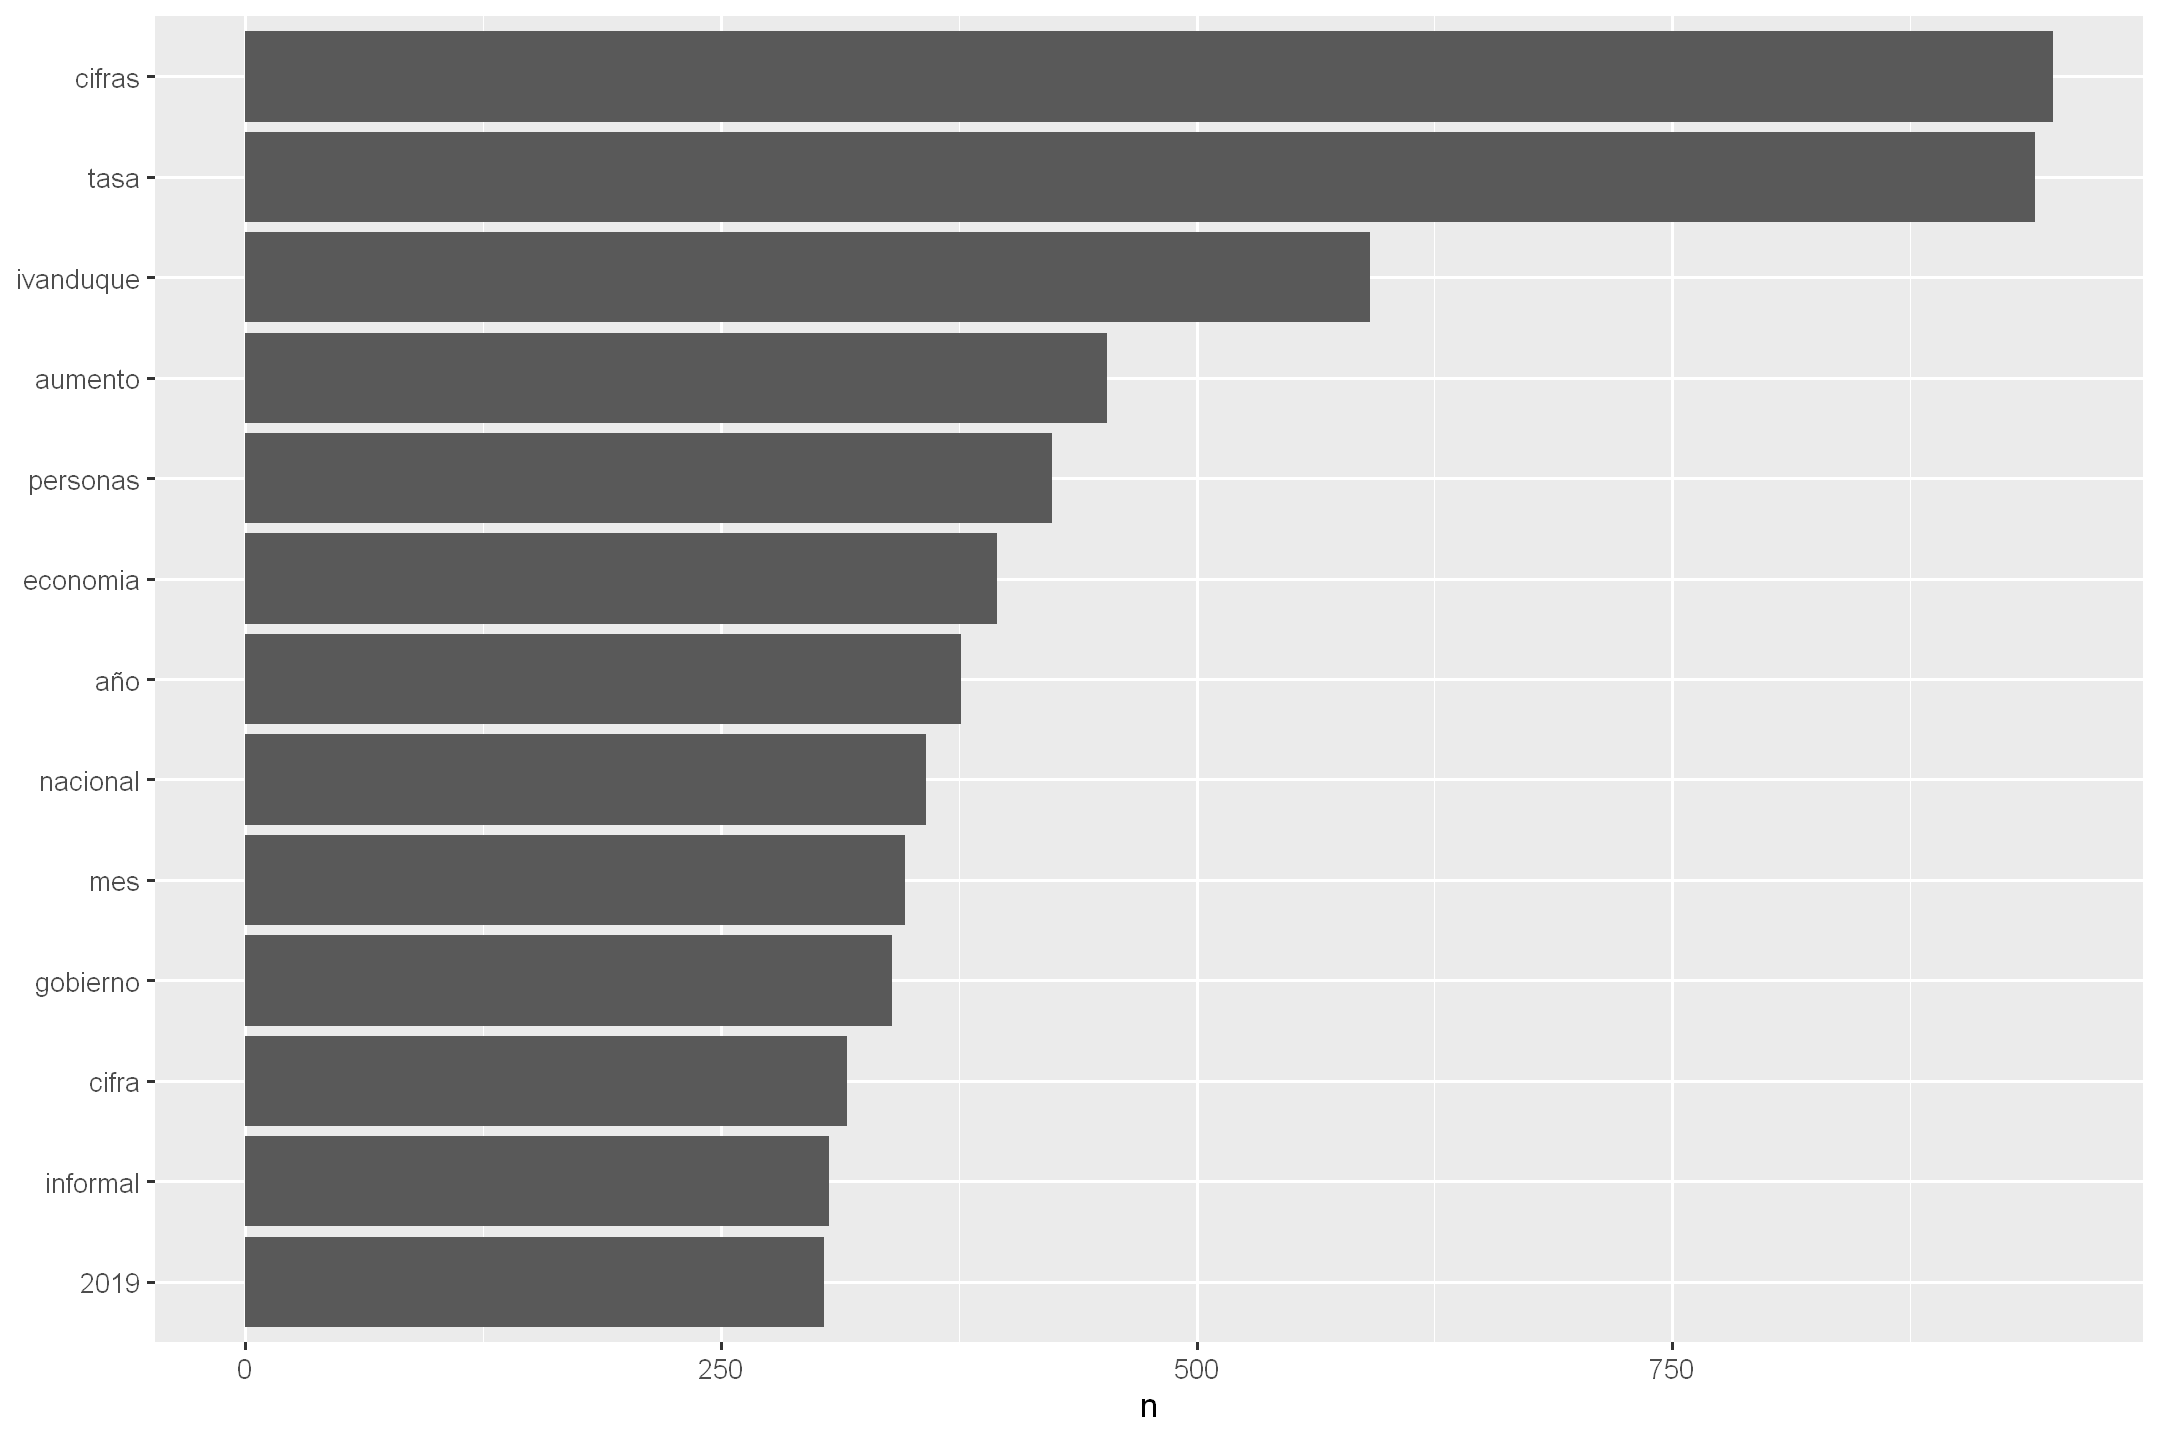

In [33]:
theme_set(theme_gray(base_size = 20))
twts.tknzds %>%
  count(word, sort = TRUE) %>%
  filter(n > 300) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(word, n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip()

In [ ]:
Otra forma común de representar las frecuencias son las nubes de palabras o *word clouds*. En este tipo de representación palabras más frecuentes tienen tamaño mayor.

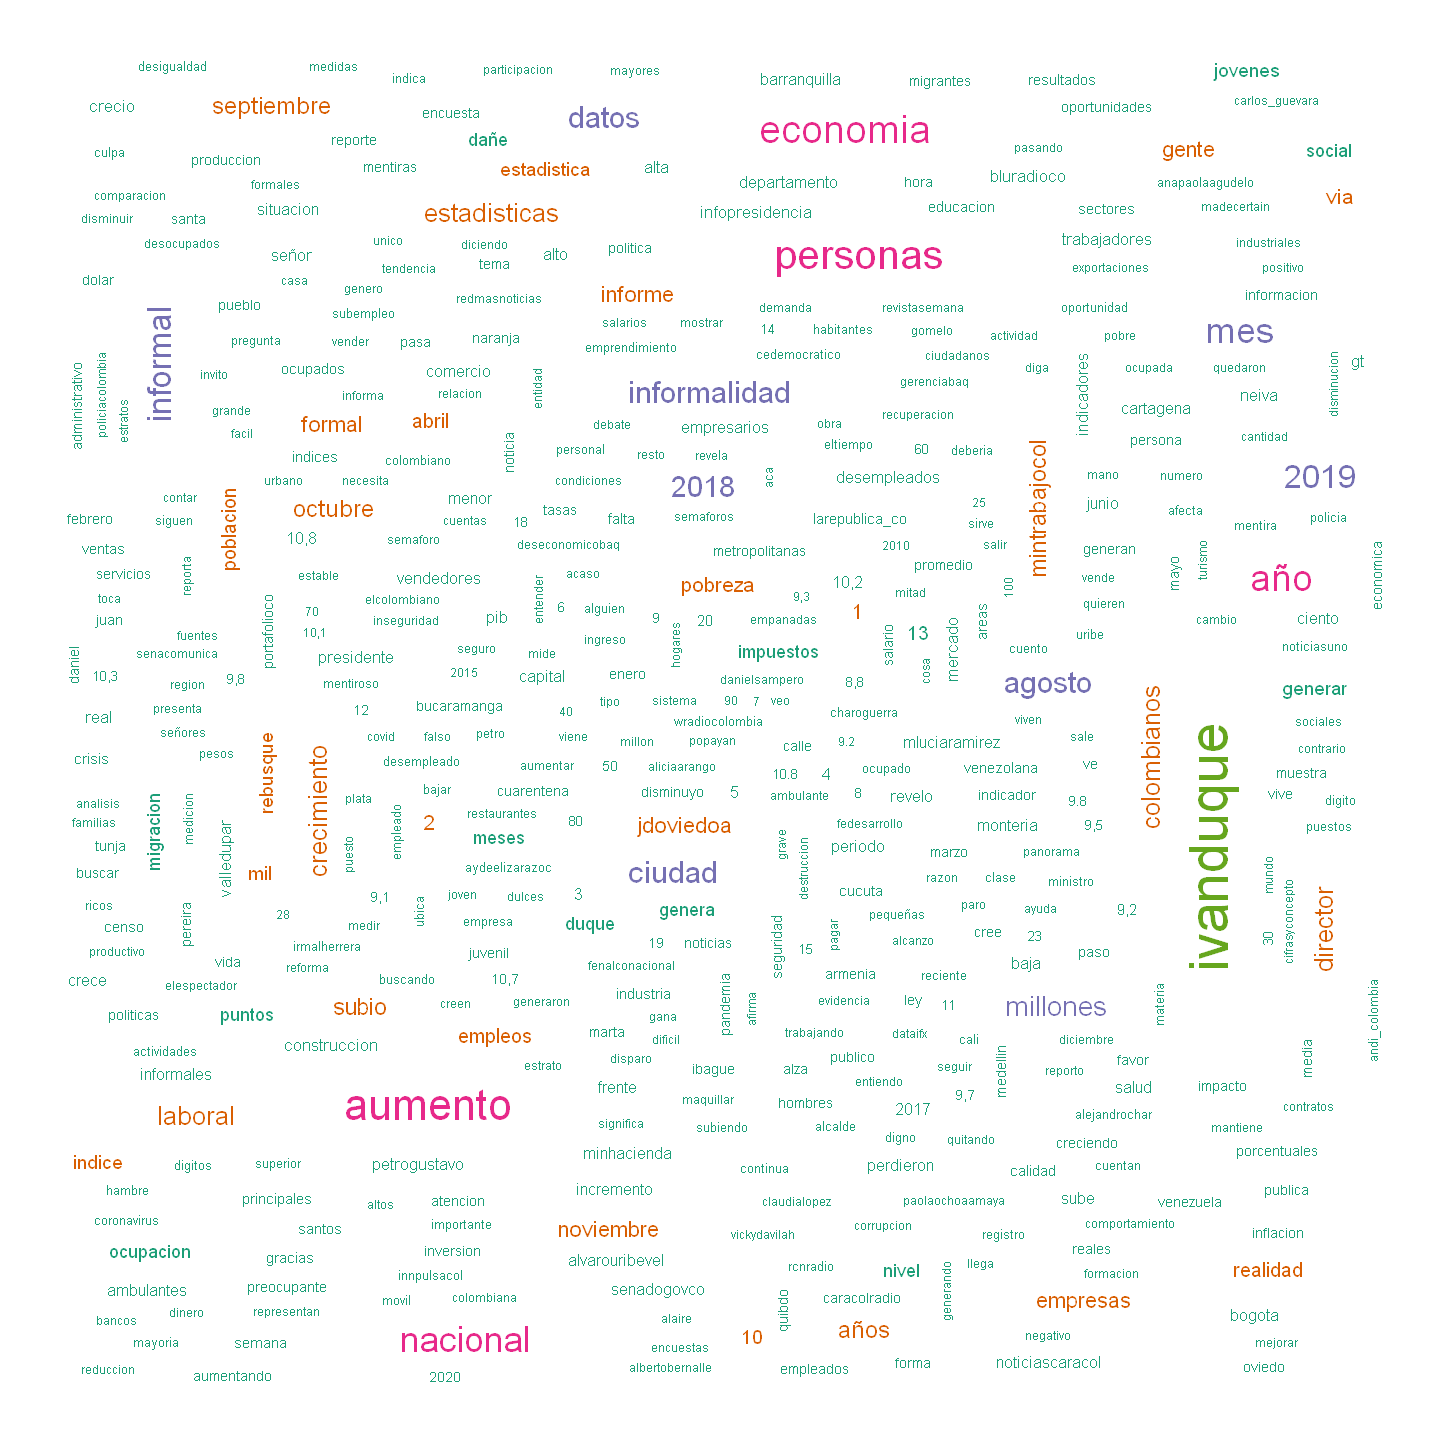

In [63]:


twts.tknzds %>%
  count(word) %>%
  with(wordcloud(word, n, max.words = 500,colors=brewer.pal(8, "Dark2")))

Una tarea para la que es útil esta aproximación es la comparación de frecuencias entre textos. En el caso particular aquí planteado pueden
imaginarse al menos dos tipos de comparación: 1. Para usuarios con más tweets; 2. Comparando periodos de tiempo, por ejemplo
meses. A continuación se realiza una comparación del primer tipo. Para ello se seleccionaron los 4 usuarios con más tweets.

Selecting by n



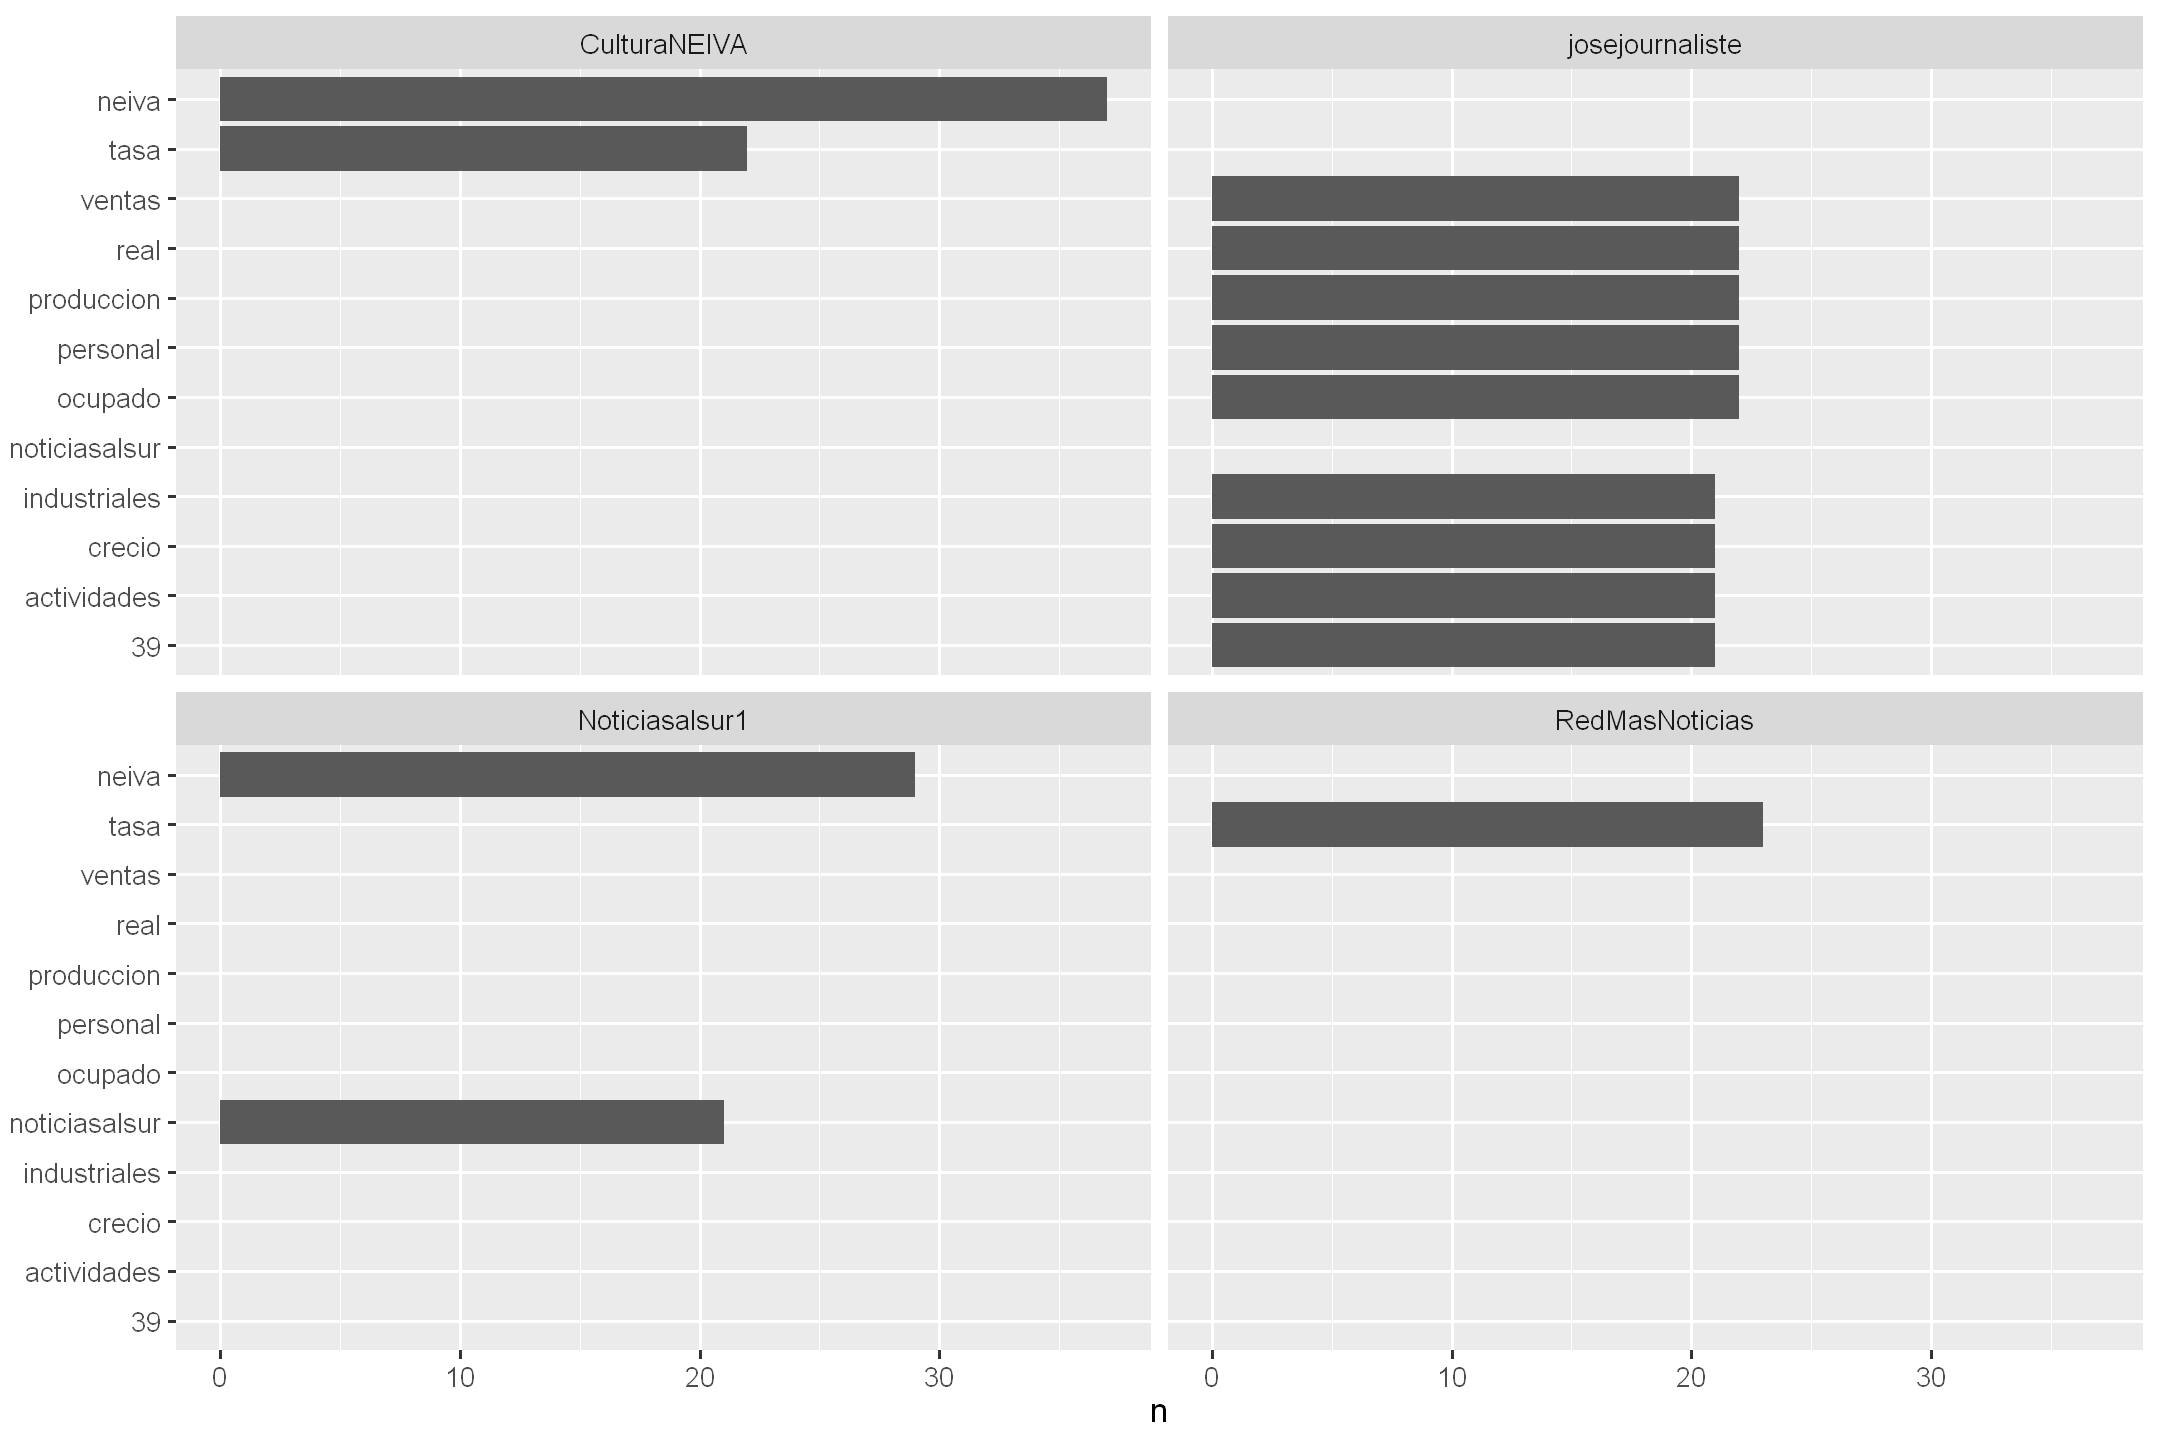

In [34]:
plbrs.usrs<-twts.tknzds %>% count(screen_name, sort=TRUE) %>% 
  top_n(4) %>% select(-n)

twts.usrs<-plbrs.usrs %>% left_join(twts.tknzds, by=c("screen_name")) %>%
count(screen_name,word, sort = TRUE) %>%
filter(n > 20) %>%
mutate(word = reorder(word, n))

twts.usrs %>%
  ggplot(aes(word, n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip()+
  facet_wrap(~ screen_name, ncol=2)

Otro procedimiento sugerido por el libro, es generar un gráfico de dispersión de frecuencias de palabras que permite comparar las frecuencia relativa en dos grupos.  Si bien en el texto de referencia dichos grupos son los autores, en la adaptación que se realizó con los datos de twitter se utilizaron los años. Para ello se realizó el siguiente procedimiento de cálculo.  

In [20]:
frcncia<-twts.tknzds %>%
  count(anio, word) %>%
  group_by(anio) %>%
  mutate(proportion = n / sum(n)) %>% 
  select(-n) %>% 
  spread(anio, proportion) %>% 
  gather(anio, proportion, `2018`:`2019`)

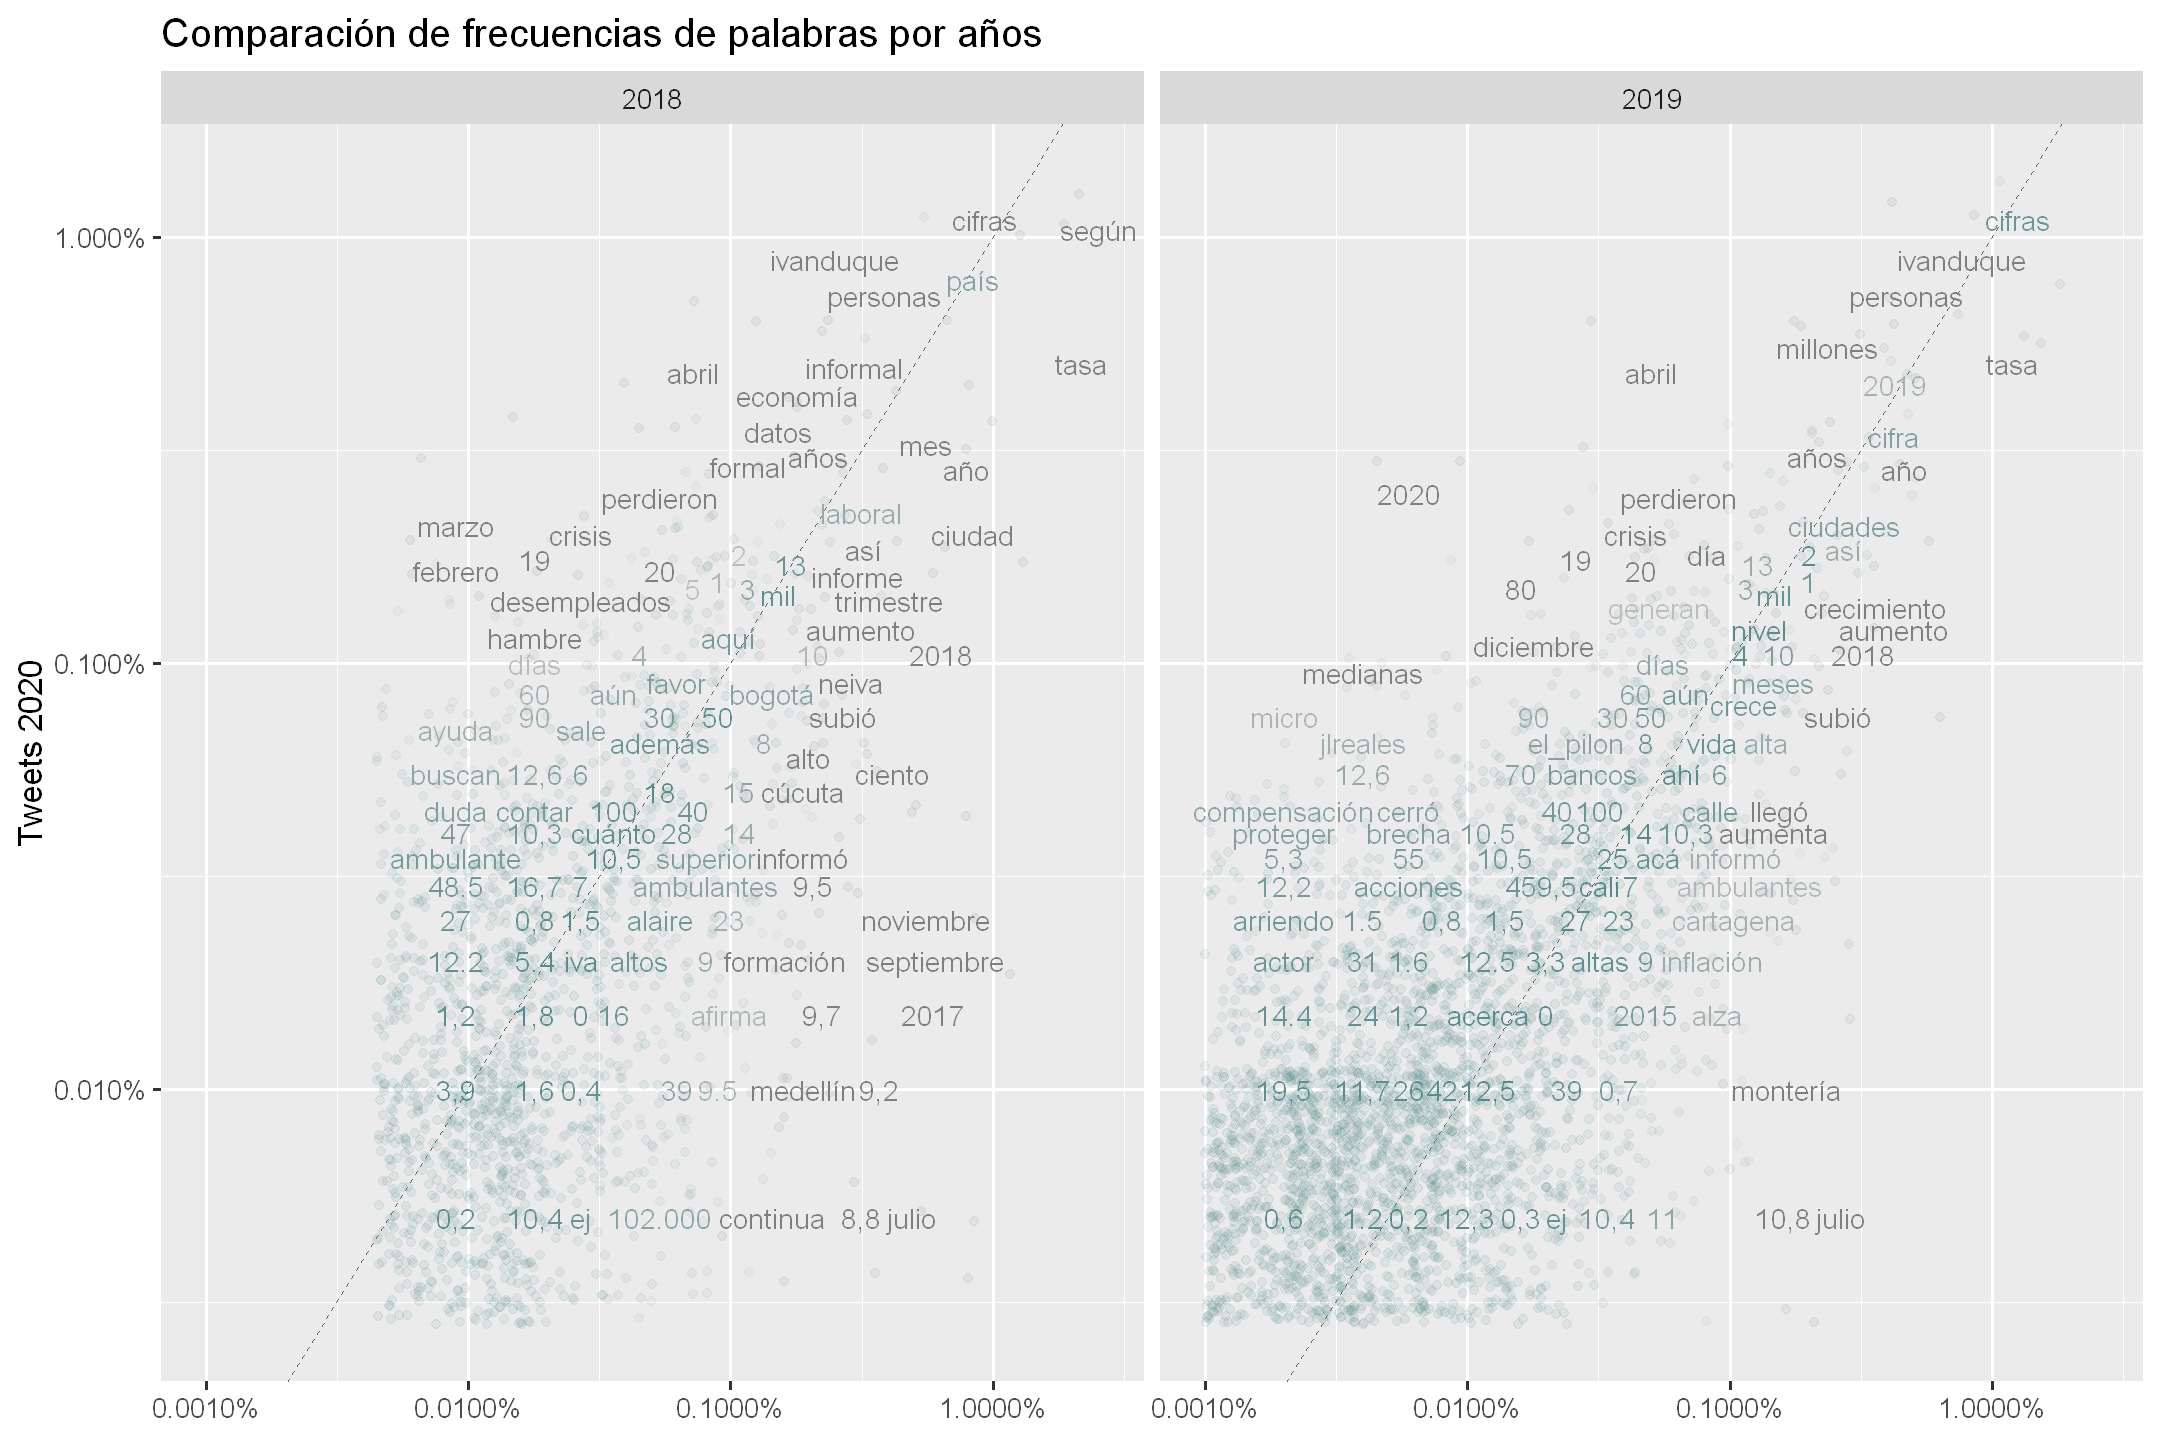

In [21]:
options(warn = -1,repr.plot.width=18, repr.plot.height=12) 

ggplot(frcncia, aes(x = proportion, y = `2020`, color = abs(`2020` - proportion))) +
  geom_abline(color = "gray40", lty = 2) +
  geom_jitter(alpha = 0.1, size = 2.5, width = 0.3, height = 0.3) +
  geom_text(aes(label = word),size=6, check_overlap = TRUE, vjust = 1.5) +
  scale_x_log10(labels = percent_format()) +
  scale_y_log10(labels = percent_format()) +
  scale_color_gradient(limits = c(0, 0.001), low = "darkslategray4", high = "gray75") +
  facet_wrap(~anio, ncol = 2) +
  theme(legend.position="none") +
  labs(y = "Tweets 2020", x = NULL)+ggtitle("Comparación de frecuencias de palabras por años")

![Proceso tidy](../image/encabezado.PNG)

# Capítulo 2: análisis de sentimientos.

De acuerdo a Ling el Análisis de Sentimientos "es el campo de estudio que analiza las emociones, actitudes, apreciaciones, evaluaciones, sentimientos y opiniones de las personas a través de entidades tales como productos, servicios, organizaciones, individuos, expediciones, eventos, tópicos y sus atributos" (Ling, B., 2012). Asimismo, hace parte del procesamiento de lenguaje natural, pertenece al campo que vincula la minería de texo (análisis, depuración y clasificación de textos) y la lingüistica computacional (modelación semántica) y hace uso, entre otras fuentes, de sitios web y redes sociales.

De igual manera, varios autores como (Bakshi et al., 2016) han analizado que el sentimiento de un texto, puede evaluarse mediante la combinación de sus palabras individuales, y el contenido del sentimiento de todo el texto como la suma del contenido del sentimiento de las palabras individuales (Ling, B., 2012). Es importante resaltar que está no es la única forma de abordar el análisis de sentimientos, pero es un enfoque de uso frecuente. En el presente capítulo *Análisis de sentimiento con texto "tidy" ordenado*, se abordara la importación de bases de datos de tuits descargados desde el año 2018, la limpieza y extracción de los textos (opiniones de los tuiteros), así como el análisis de polaridad de cada uno de las tuits, se presentarán los contrastes con las cifras de desempleo desde el año 2018 y, finalmente, el glosario y las referencias bibliográficas. Cabe resaltar que  los siguientes capítulos se abordaran algoritmos más sofisticados que hacen parte del aprendizaje automático (*Machine Learning*) que pueden permiitr una clasificación más precisa de textos y documentos.

El proceso general para la realización de un análisis de sentimientos en formato tidy tiene la siguiente estructura: 1. se parte de un texto que se transforma a formato tidy mediente el comando unnest_tokens. Dicha tabla se complementa con un lexicón, esto es un archivo que contiene las palabras y una indicación del sentimiento asociado a ellas, preferiblemente en formato numérico.  Cuando se trata de una indicación numérica del sentimiento, suele llamarsele polaridad.   Posteriormente, los datos se agrupan para una variable categórica, por ejemplo un intervalo de tiempo,  y se obtiene una medida del sentimiento predominante.   En R este paso suele preceder a la visualización del resultado.

## 2.1  Léxico AFINN

El léxico AFINN es un conjunto de palabras marcadas asociadas una escala de puntaje de -5 (muy negativo) y +5 (muy positivo), asociadas respectivamente a sentimientos negativos y positivos. Fue desarrollado por Finn Årup Nielsen y contiene más de 2.477 palabras únicas en español, así como 15 frases. AFINN se basa en unigramas escritos en diferentes idiomas como ingles, español y danés.  Adicionalmente, permite especificar sensasiones como *alegría*, *enojo*, *miedo*, *sorpresa*, *confianza*, entre otras.  A continuación se presenta un ejemplo de la asociación entre palabras y polaridad en un fragmento de AFINN, considerando únicamente la palabra y el puntaje.


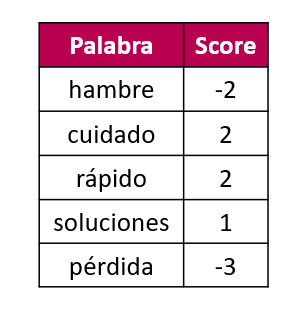
                           

                                                      Lexico AFINN

Para el desarrollo de este notebook, se describiran por pasos los procedimientos que se deben realizar para realizar un análisis de sentimientos sobre una base de datos de Twitter pre-cargada en la carpeta ***/data/*** del proyecto. 

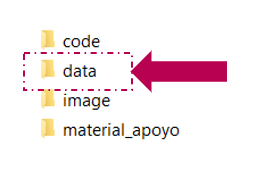


                    Figura 2. Directorio de archivos

Como se mencionaba, en la carpeta *data* se encuentra el archivo *lexico_afinn.en.es.csv*, está compuesto por tres columnas; la primera y la última son las labras en los idiomas español e inglés respectivamente. Adicionalmente, en la columna del medio se puede observar la puntuación de cada una de ellas en relación con el sentimiento.  Para el presente documento únicamente se importó la palabra en español y la columna que representa su puntuación.

La importación se realiza mediante la función *read_csv*.  Para la lectura de caracteres propios del español, como las tildes y la ñ, se especifica que la codificación es "Latin1". 

In [36]:
#suppressWarnings(suppressMessages(suppressPackageStartupMessages({dts<-read_csv(".\\data\\lexico_afinn.en.es.csv")})))
#dts<-dts[!duplicated(dts),]
#glimpse(dts[,1:20])

afnn<-read_csv(".\\data\\lexico_afinn.en.es.csv") %>% 
  mutate(word=parse_character(word, locale = locale(encoding = "Latin1"))) %>% 
  select(word, pntcn=Puntuacion) %>% mutate(word=chartr("áéíóú", "aeiou", word))
glimpse(afnn)

Parsed with column specification:
cols(
  word = col_character(),
  Puntuacion = col_double(),
  `WordE;` = col_character()
)



Rows: 2,476
Columns: 2
$ word  <chr> "a bordo", "abandona", "abandonado", "abandonar", "abatido", ...
$ pntcn <dbl> 1, -2, -2, -2, -2, -3, -3, -3, -3, -3, 1, 2, 2, 2, 2, 2, 2, 2...


A continuación se genera y visualiza una línea del tiempo de sentimientos desde agosto de 2018 hasta finales de mayo de 2020.  La unidad temporal en la que se agregan los datos es la semana.  Se comienza realizando una unión de tablas o join entre la tabla de contiene el texto de los tweets y la que los califica en términos de semtimientos:

In [38]:
twts.sntmnts<-twts.tknzds %>% inner_join(afnn, by=c("word"="word")) 
glimpse(twts.sntmnts)

Rows: 4,825
Columns: 9
$ user_id     <dbl> 3.481490e+07, 3.481490e+07, 3.481490e+07, 3.481490e+07,...
$ status_id   <dbl> 1.270370e+18, 1.255508e+18, 1.266420e+18, 1.266420e+18,...
$ screen_name <chr> "JuanLuisCasCo", "JuanLuisCasCo", "JuanLuisCasCo", "Jua...
$ crdo.dia    <date> 2020-06-09, 2020-04-29, 2020-05-29, 2020-05-29, 2020-0...
$ crdo.hra    <Period> 14H 58M 20S, 14H 44M 1S, 17H 24M 0S, 17H 24M 0S, 4H ...
$ word        <chr> "hambre", "hambre", "matar", "hambre", "presion", "pres...
$ anio        <chr> "2020", "2020", "2020", "2020", "2020", "2020", "2020",...
$ ms          <chr> "2020-06", "2020-04", "2020-05", "2020-05", "2020-06", ...
$ pntcn       <dbl> -2, -2, -3, -2, -1, -1, -3, 2, -2, 3, 2, 2, -2, -2, -1,...


El siguiente paso es obtener la semana con base en la variable que contiene el día. El sentimiento por semana, se obtiene
como una suma de la polaridad de las palabras contenidas en los tweets de esa semana. Para la representación gráfica es
útil tener un día de referencia, para ello se calculó el que corresponde a la mitad de la semana. Se deja también, como variable de agregación
el mes. Dado que una semana puede caer en dos meses, se utiliza la moda para asignarle el més en el que estuvo más días.  A 
continuación se puede ver el procedimiento y dar un vistazo al resultado final.

In [40]:

Mode <- function(x) {
  ux <- unique(x)
  ux[which.max(tabulate(match(x, ux)))]
}

sntmnts.smns<-twts.sntmnts %>% filter(word!="desempleo") %>% 
  mutate(ms=month(crdo.dia), ms.dia=month(crdo.dia, label=TRUE),
         nro.smna=week(crdo.dia)) %>% 
  group_by(anio,nro.smna) %>% 
  summarise(sntmnto=sum(pntcn), anio=Mode(anio), 
            mdia.smna=mean.Date(crdo.dia), ms=Mode(ms), 
            ms.dia=Mode(ms.dia)) 
glimpse(sntmnts.smns)

`summarise()` regrouping output by 'anio' (override with `.groups` argument)



Rows: 101
Columns: 6
Groups: anio [3]
$ anio      <chr> "2018", "2018", "2018", "2018", "2018", "2018", "2018", "...
$ nro.smna  <dbl> 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...
$ sntmnto   <dbl> -20, -12, 3, -18, 4, -11, -8, -12, -25, -4, 8, -2, -4, -3...
$ mdia.smna <date> 2018-08-03, 2018-08-08, 2018-08-15, 2018-08-24, 2018-08-...
$ ms        <dbl> 8, 8, 8, 8, 8, 9, 9, 9, 9, 10, 10, 10, 10, 11, 11, 11, 11...
$ ms.dia    <ord> ago, ago, ago, ago, ago, sept, sept, sept, sept, oct, oct...


In [ ]:
A continuación se representan los resultados obtenidos. Como ya se dijo los valores negativos corresponden a sentimientos 
igualmente negativos. 

`summarise()` ungrouping output (override with `.groups` argument)



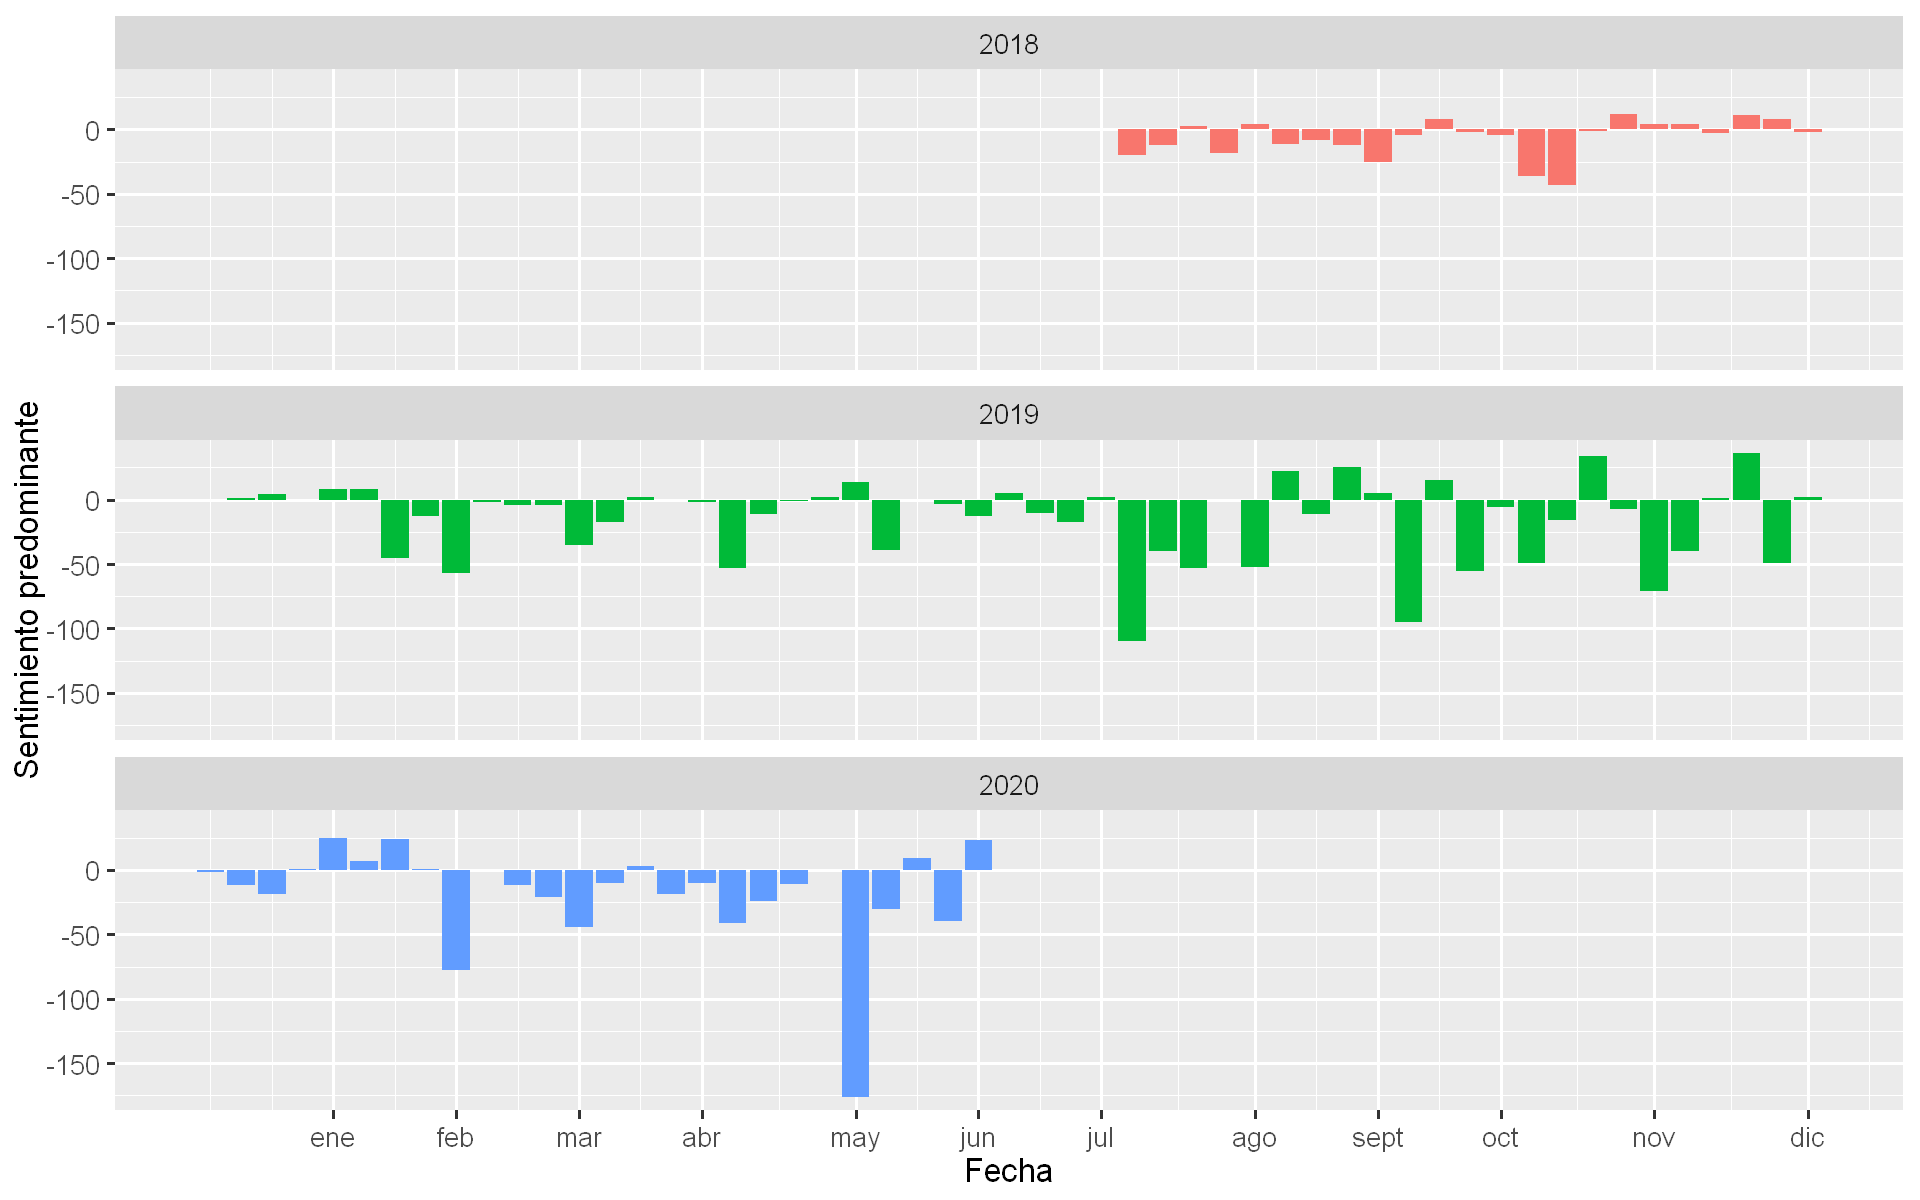

In [42]:

brks<-sntmnts.smns %>% group_by(ms.dia) %>% 
  dplyr::summarise(nro.smna=max(nro.smna))

options(warn = -1,repr.plot.width=16, repr.plot.height=10) 

ggplot(sntmnts.smns, aes(nro.smna, sntmnto, fill = anio)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~anio, ncol = 1)+scale_y_continuous("Sentimiento predominante")+
  scale_x_continuous("Fecha", breaks=brks$nro.smna, 
                     labels = brks$ms.dia)

Por otra parte, esta información debe compararse con la tasa de desempleo, dado que los tweets suelen referirse o reaccionar a ella.  Se construyó una serie, con base en datos de la página web del DANE. Los mismos se pueden ver a continuación:

`summarise()` ungrouping output (override with `.groups` argument)



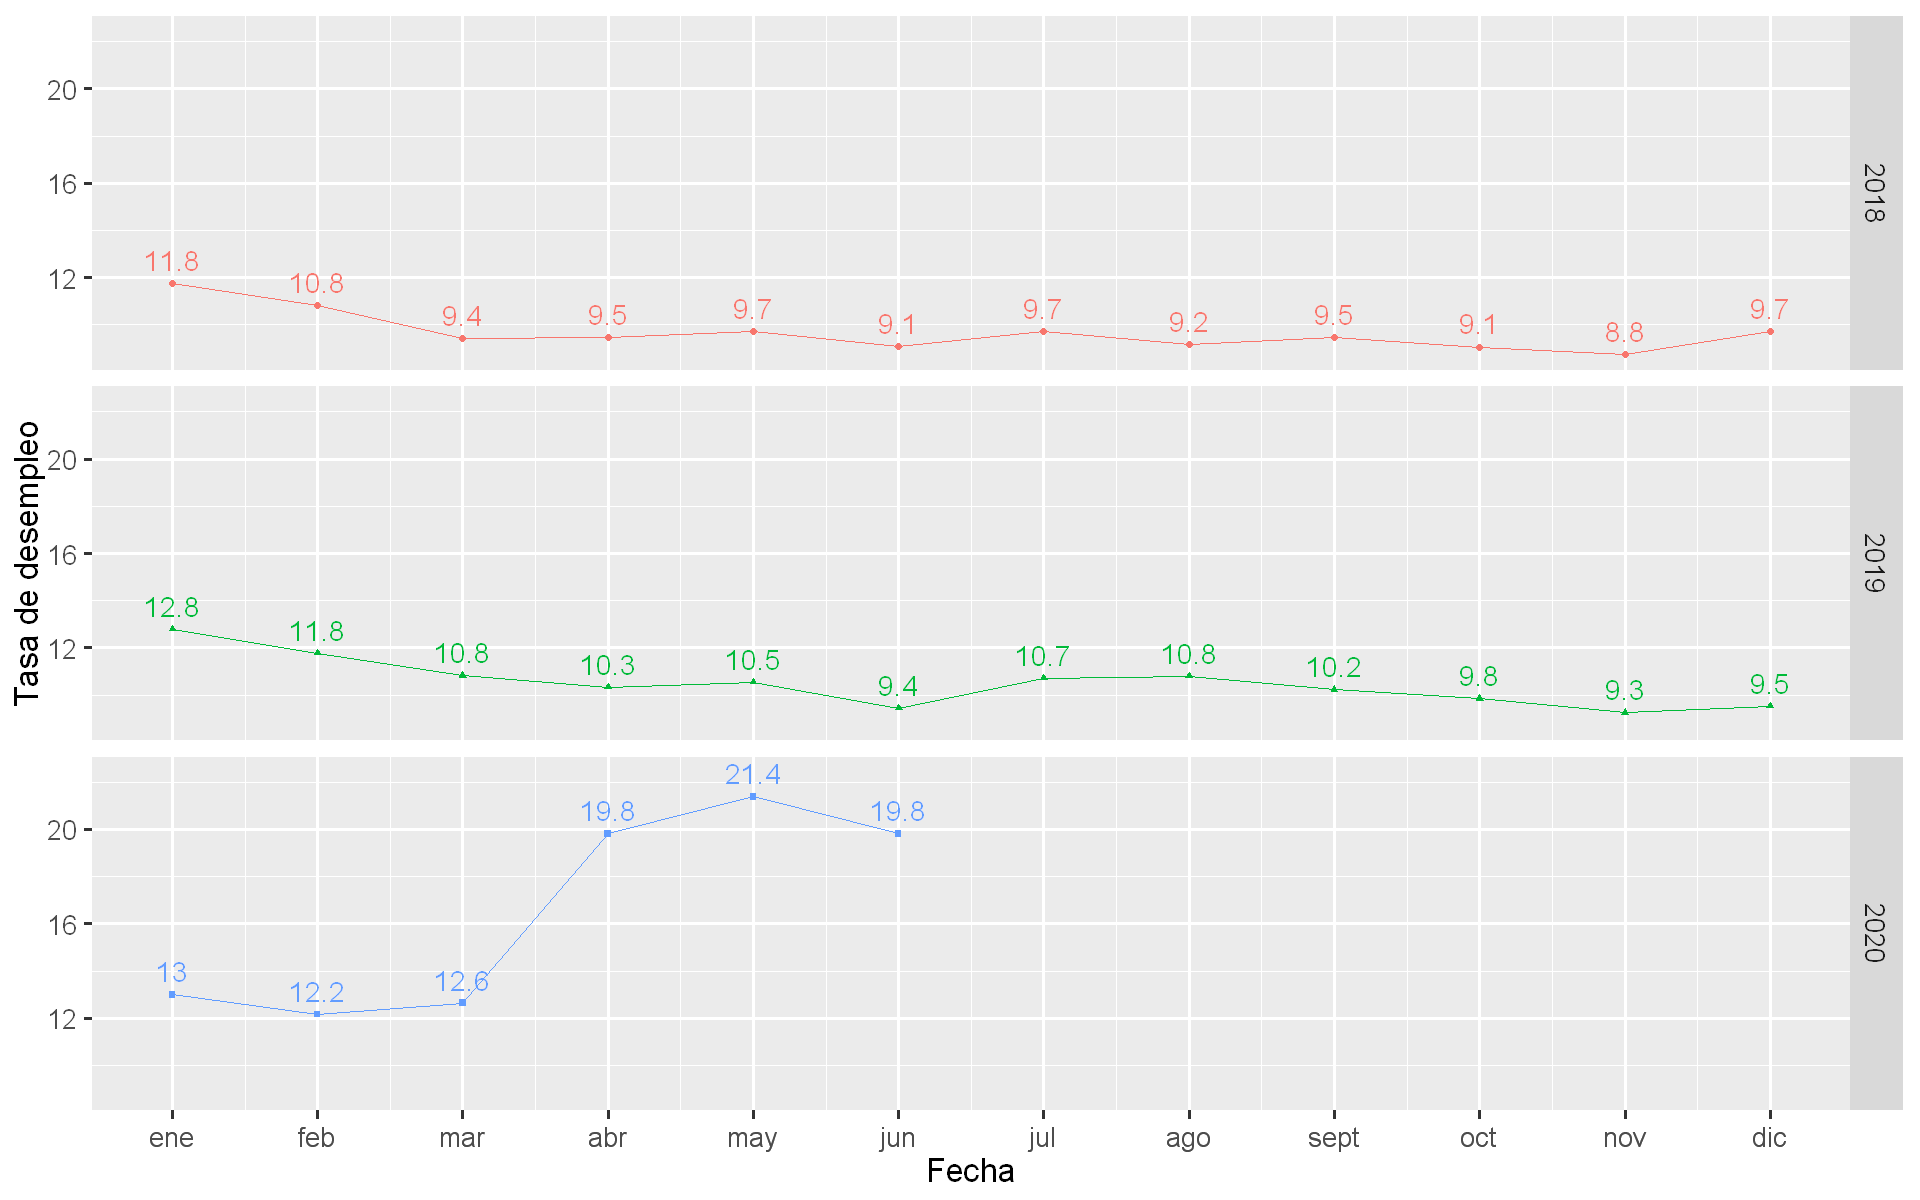

In [43]:
setwd('C:\\1Proyectos\\2020_06_28_Tweets_Dane_2\\Datos\\')
dsmpleo<-read.xlsx("base desempleo.xlsx")

names(dsmpleo)[1]<-"ms"
dsmpleo1<-dsmpleo %>% pivot_longer(names_to="anios", values_to="tsa", -ms) %>% 
  mutate(anio.ms=ymd(paste0(anios,"-",ms, "-28")),
         ms.nmro=month(anio.ms), ms.dia=month(anio.ms,label=TRUE)) %>% 
  filter(anios%in%c("2018","2019","2020"))

brks<-dsmpleo1 %>% group_by(ms.dia) %>% 
  dplyr::summarise(ms.dia=max(ms.dia))

options(warn = -1,repr.plot.width=16, repr.plot.height=10) 

ggplot(dsmpleo1, aes(x=ms.nmro, y=tsa, color=anios, shape=anios))+
  geom_point()+
  geom_line()+geom_text(aes(x=ms.nmro, y=tsa+1, label=round(tsa,1)), size=6)+
  facet_grid(facets = anios ~ .) +scale_y_continuous("Tasa de desempleo")+
  scale_x_continuous(name="Fecha", breaks=dsmpleo1$ms.nmro,
                     labels=dsmpleo1$ms.dia)+ 
  theme(legend.position = "none")

In [ ]:
La comparación de las dos gráficas puede observarse en la siguiente figura: 

![](../image/Cmpra_srs.png)

Finalmente, es fácil visualizar las palabras predominantes con polaridad positiva y negativa

`summarise()` regrouping output by 'word' (override with `.groups` argument)



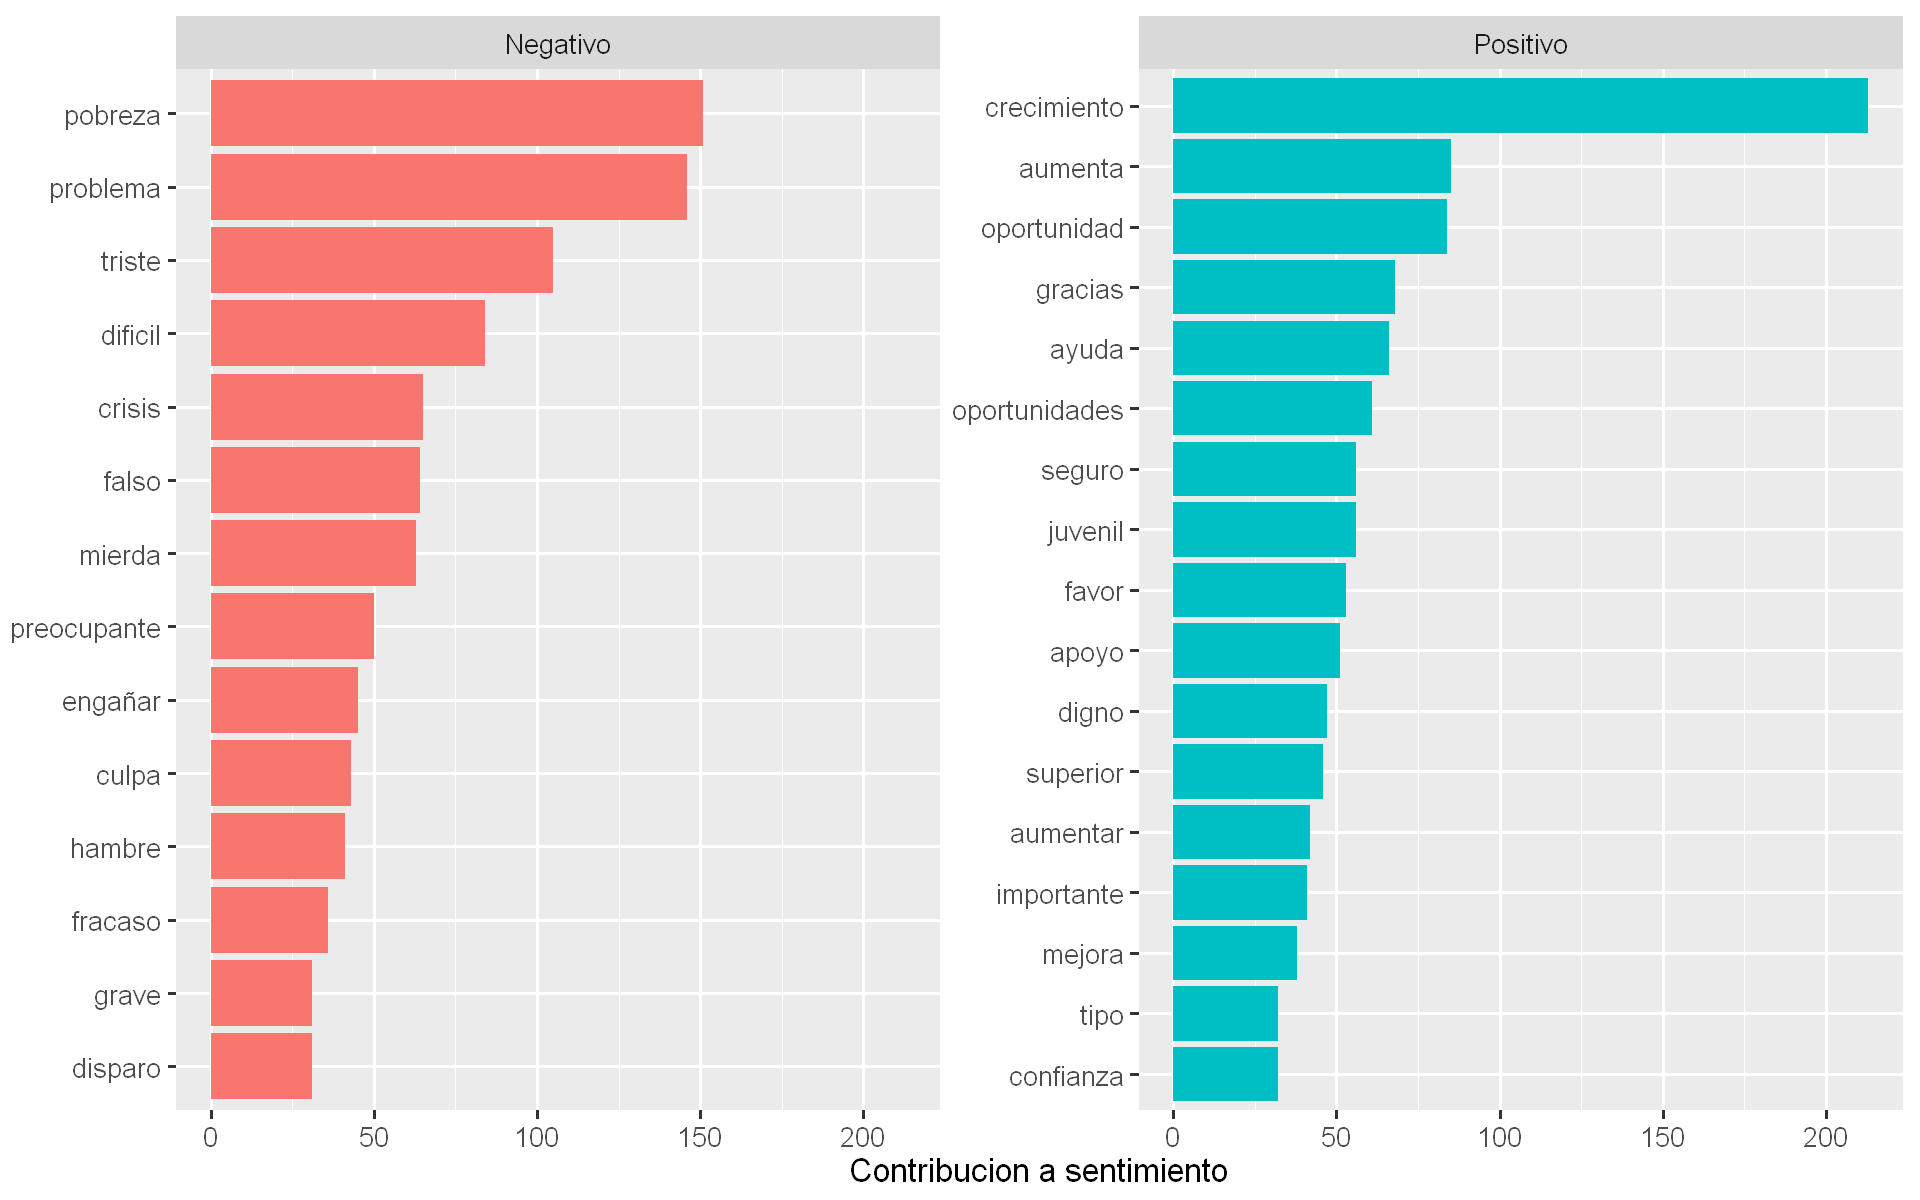

In [47]:
twts.sntmnts1<-twts.sntmnts %>% 
  mutate(plrdd=ifelse(pntcn<0, "Negativo", "Positivo")) %>% 
  filter(word!="desempleo") %>% 
  group_by(word, plrdd) %>% summarise(conteo=n()) %>% arrange(-conteo) %>% 
  ungroup() %>% slice_max(conteo,n=30, with_ties=TRUE)

ggplot(twts.sntmnts1, aes(x=fct_reorder(word, conteo), y=conteo, fill=plrdd))+
  geom_col()+facet_wrap(~plrdd, scales="free_y")+
  labs(y = "Contribucion a sentimiento",
       x = NULL) +
  coord_flip()+theme(legend.position = "none")

# Capítulo 3. Análisis de palabras y frecuencias de documentos.

Una cuestión central en minería de texto y procesamiento de lenguaje natural es cómo cuantificar de qué trata un documento.  Una medida de qué tan importante es una palabra es la frecuencia con que aparece.

Una aproximación es quitar los stop words, pero estos son más importantes en unos documentos que en otros. Otra aproximación es observar la frecuencia inversa del documento, que reduce el peso de las palabras más usadas e incrementa el peso de las palabras menos usadas.  Esto puede ser combinado por la frecuencia de los términos para obtener para un término el td-idf: la frecuencia de un término ajustada por cómo de raramente es usada.  A esta aproximación se le conoce como idf. Aunque tiene fundamentos teóricos dudosos, es útil en análisis exploratorio de texto.

td-idf se destina a medir qué tan importante es una palabra de un documento en una colección de documentos.  Por ejemplo un sitio web en un conjunto de sitios web. Su fórmula es la siguiente.

idf(término)=ln(n_documentos/n_documentos_conteniendo_término)

En el primer ejemplo del libro se compara la información de algunos libros de Jane Austen respecto del conjunto de su obra.  En el presente caso se estudiará las palabras más usadas en un periodo respecto a otros periodos. Es de especial interés el desempleo debido a la pandemia, cuyos efectos se empezaron a sentir con fuerza desde el 23 de marzo, día de inicio de la cuarentena obligatoria.

In [49]:
plbrs.anio<-twts.tknzds %>% count(anio, word, sort=TRUE) 
ttl.plbrs<-plbrs.anio %>% group_by(anio) %>% summarise(ttl=sum(n))
anio.plbrs <- left_join(plbrs.anio, ttl.plbrs)
head(anio.plbrs)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "anio"



anio,word,n,ttl
<chr>,<chr>,<int>,<int>
2019,cifras,626,47828
2019,tasa,598,47828
2019,ivanduque,386,47828
2019,aumento,332,47828
2019,economia,275,47828
2018,tasa,242,10543


En el dataframe resultante existe una fila para cada combinación de año y palabra. "n" es el total de ocurrencias de una palabra 
y ttl es el total de palabras en un año.  En el siguiente gráfico se muestra la distribución total de palabras, graficando
en un histograma n/total.  Igual que en el ejercio del libro se observa que la cola de la distribución es larga. Es decir, hay muchas palabras que aparecen con poca frecuencia.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



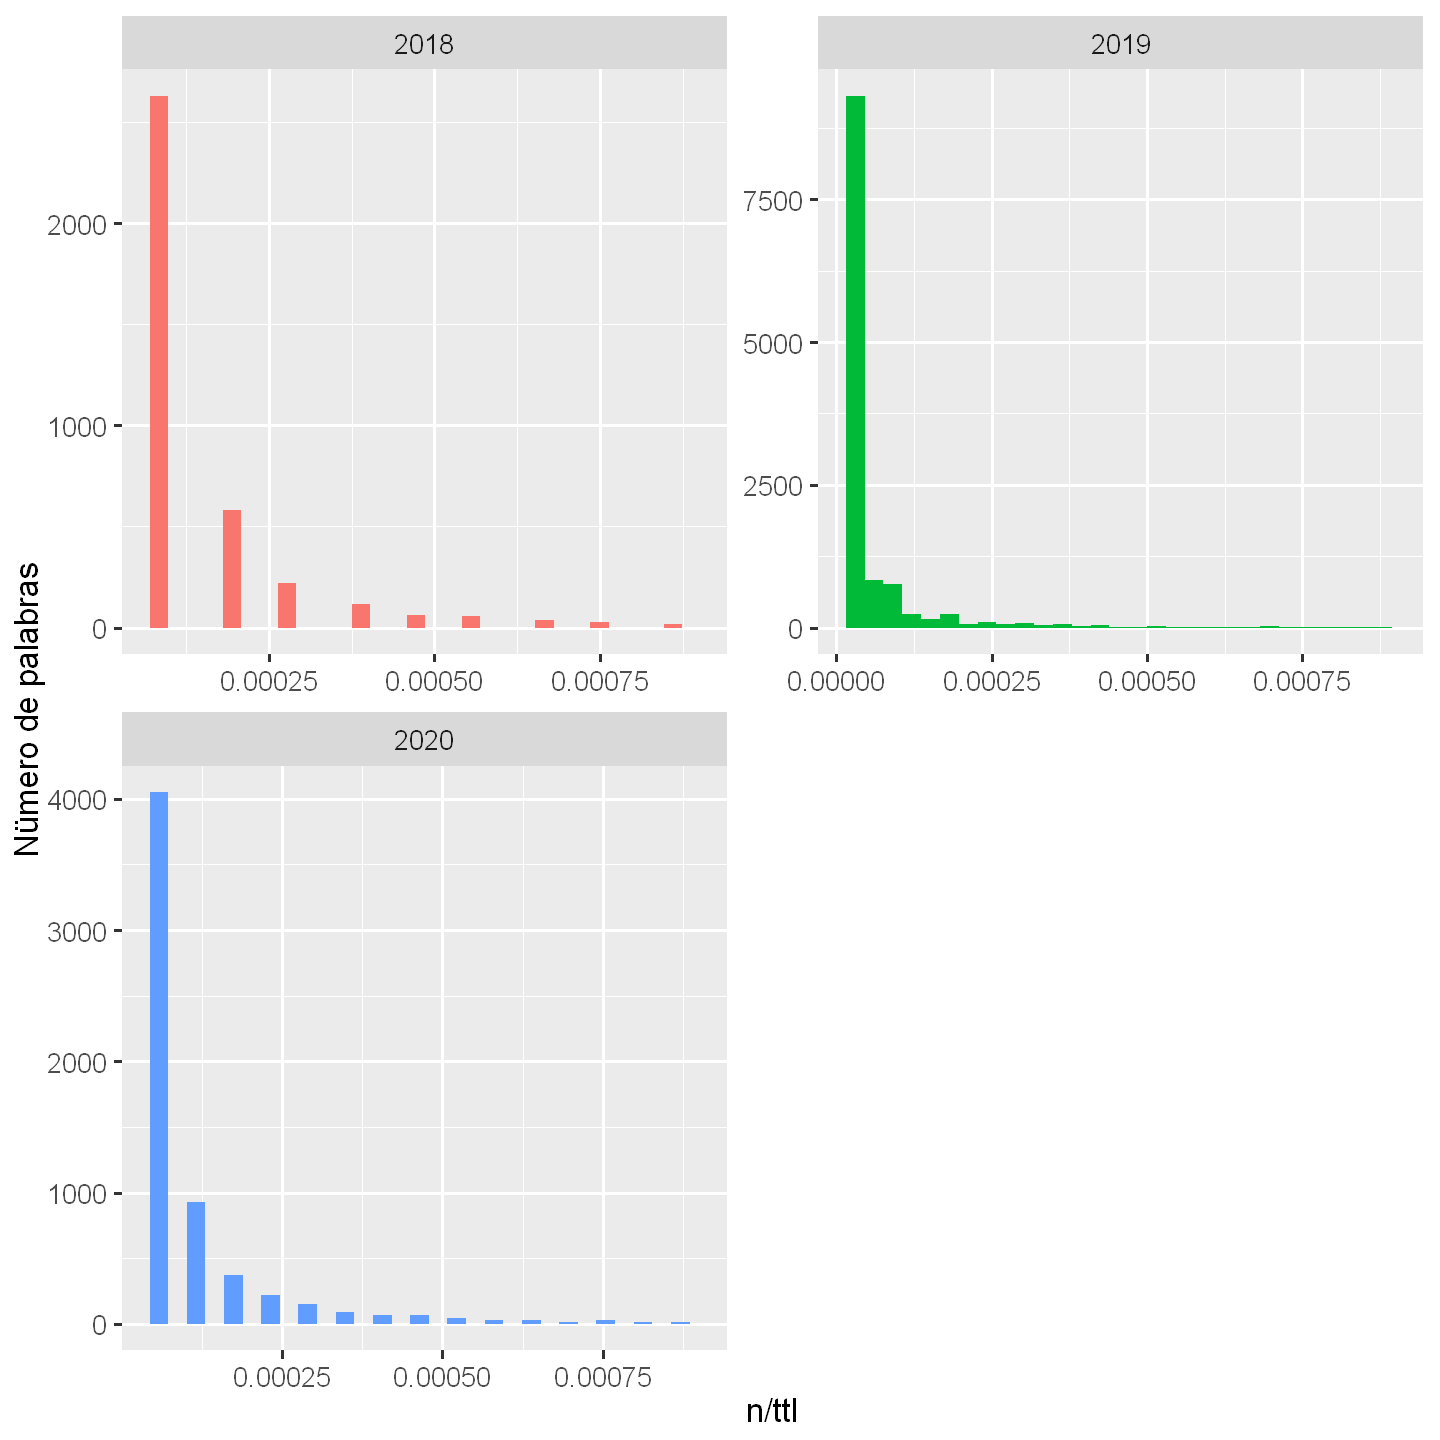

In [51]:
options(warn = -1,repr.plot.width=12, repr.plot.height=12) 

ggplot(anio.plbrs, aes(n/ttl, fill = anio)) +
  geom_histogram(show.legend = FALSE) +
  xlim(NA, 0.0009) + scale_y_continuous("Nümero de palabras")+
  facet_wrap(~anio, ncol = 2, scales = "free")

De acuerdo a la ley de Zipf, existe una relación inversa entre la frecuencia de una palabra y su rango. Con base en esta idea
se calcula y examina el rango de las palabras de la tabla anterior.

In [52]:
frcncia.rngo <- anio.plbrs %>% 
  group_by(anio) %>% 
  mutate(rngo = row_number(), 
         `trmno.frcncia` = n/ttl)

head(frcncia.rngo,10)

anio,word,n,ttl,rngo,trmno.frcncia
<chr>,<chr>,<int>,<int>,<int>,<dbl>
2019,cifras,626,47828,1,0.013088567
2019,tasa,598,47828,2,0.012503136
2019,ivanduque,386,47828,3,0.008070586
2019,aumento,332,47828,4,0.006941541
2019,economia,275,47828,5,0.005749770
2018,tasa,242,10543,1,0.022953619
2019,venezolanos,242,47828,6,0.005059798
2019,personas,235,47828,7,0.004913440
2019,año,231,47828,8,0.004829807


La ley de Zipf se puede visualizar graficando el ranking en el eje x y la frecuencia en el y, usando escalas logarítmicas.

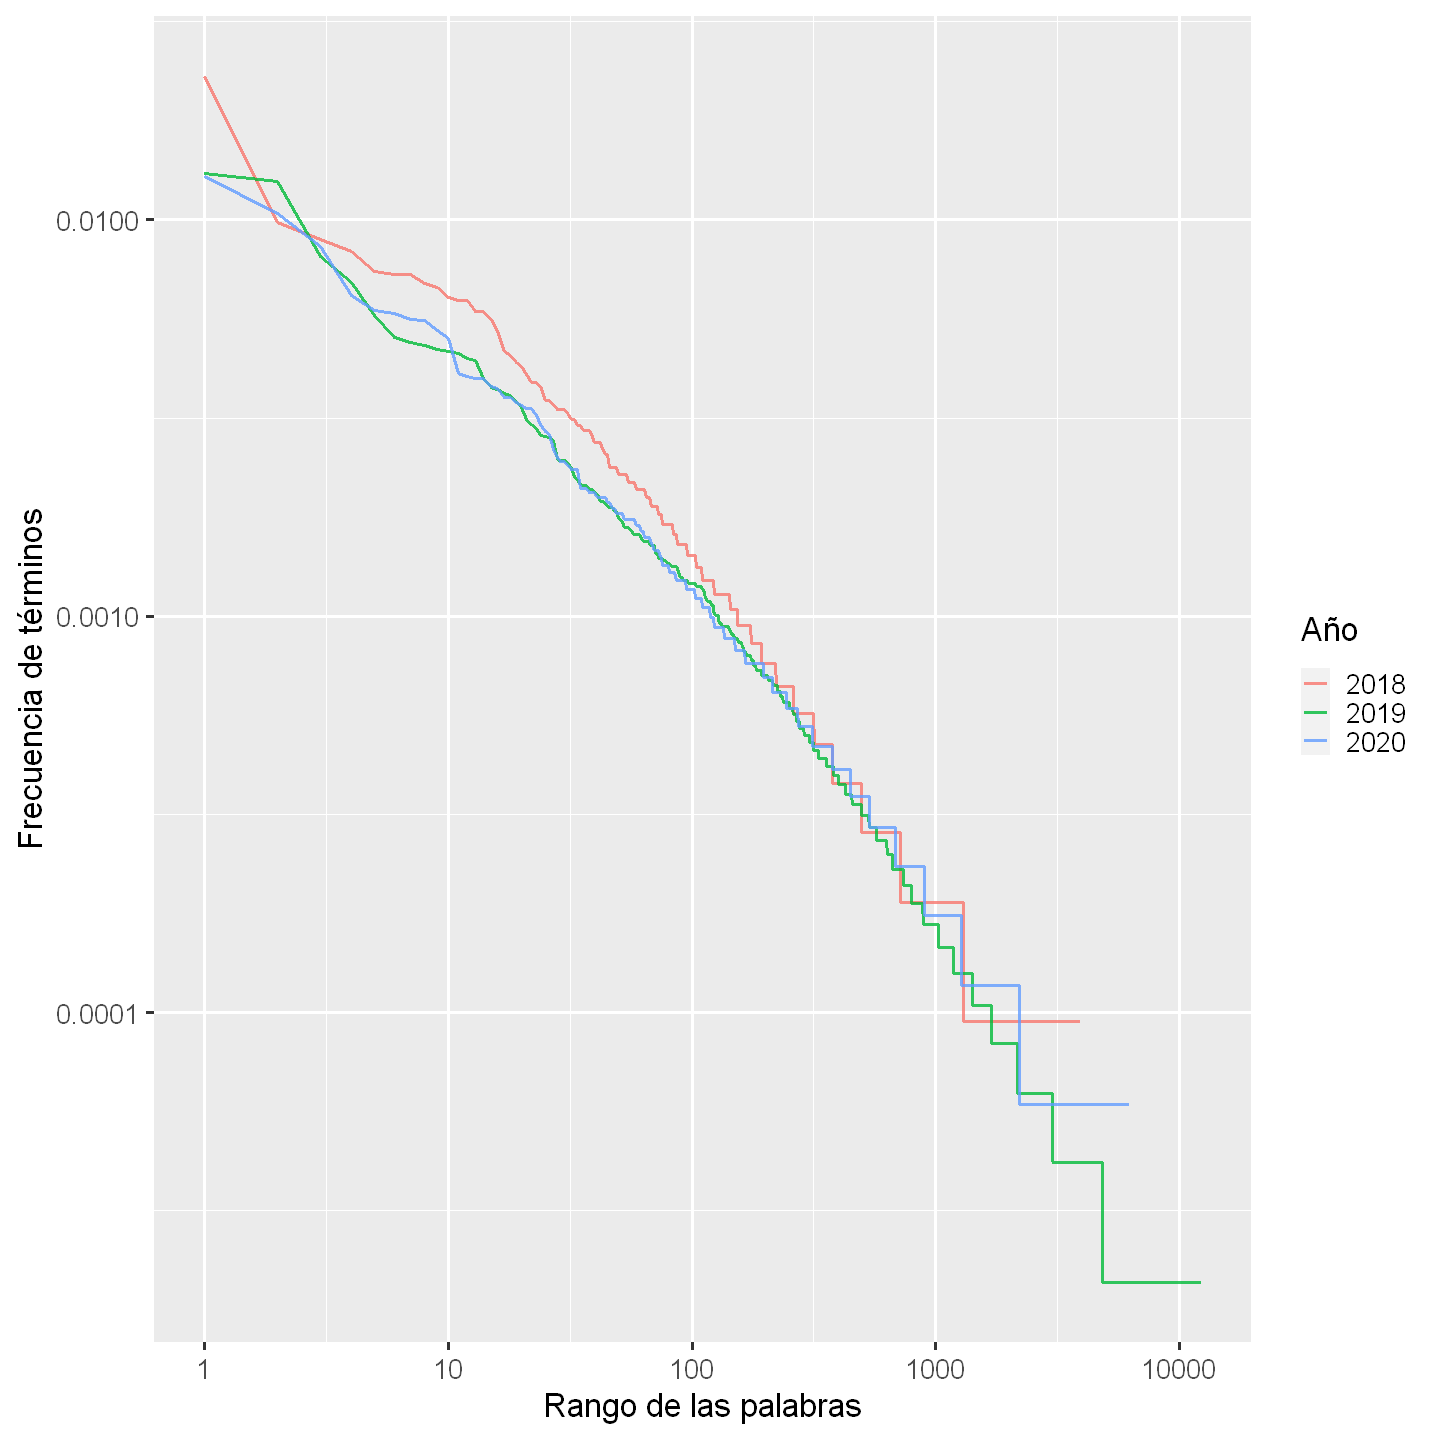

In [53]:
options(scipen=999)
frcncia.rngo %>% 
  ggplot(aes(rngo, trmno.frcncia, color = anio)) + 
  geom_line(size = 1.1, alpha = 0.8) + 
  scale_x_log10("Rango de las palabras")+
  scale_y_log10("Frecuencia de términos")+scale_colour_discrete("Año")

En coordenadas log-log los tres años tienen un comportamiento similar, especialmente entre 2019 y 2020. El gráfico también permite observar la pendiente
negativa entre el logaritmo del rango y el de la frecuencia de términos. El libro propone determinar el exponente de la 
relación de potencia para una parte del gráfico, mediante una regresión.  La aplicación de ese concepto al subconjunto de
palabras de la base de tweets con rango entre 100 y 1000 se realiza de la siguiente forma:

In [54]:
sbcnjnto.rngo <- frcncia.rngo %>% 
  filter(rngo < 1000,
         rngo > 10)

lm(log10(trmno.frcncia) ~ log10(rngo), data = sbcnjnto.rngo)


Call:
lm(formula = log10(trmno.frcncia) ~ log10(rngo), data = sbcnjnto.rngo)

Coefficients:
(Intercept)  log10(rngo)  
    -1.2845      -0.8177  


La ley clásica de Zipf dice que la frecuencia es proporcional a 1/rango. Lo cual se cumple de manera general en la relación observada.
La representación de la predicción lograda, se puede ver como una línea punteada en el siguiente gráfico.  Se observa que 
el uso de palabras comunes es menor de lo que cabría esperarse para las palabras más comunes. 

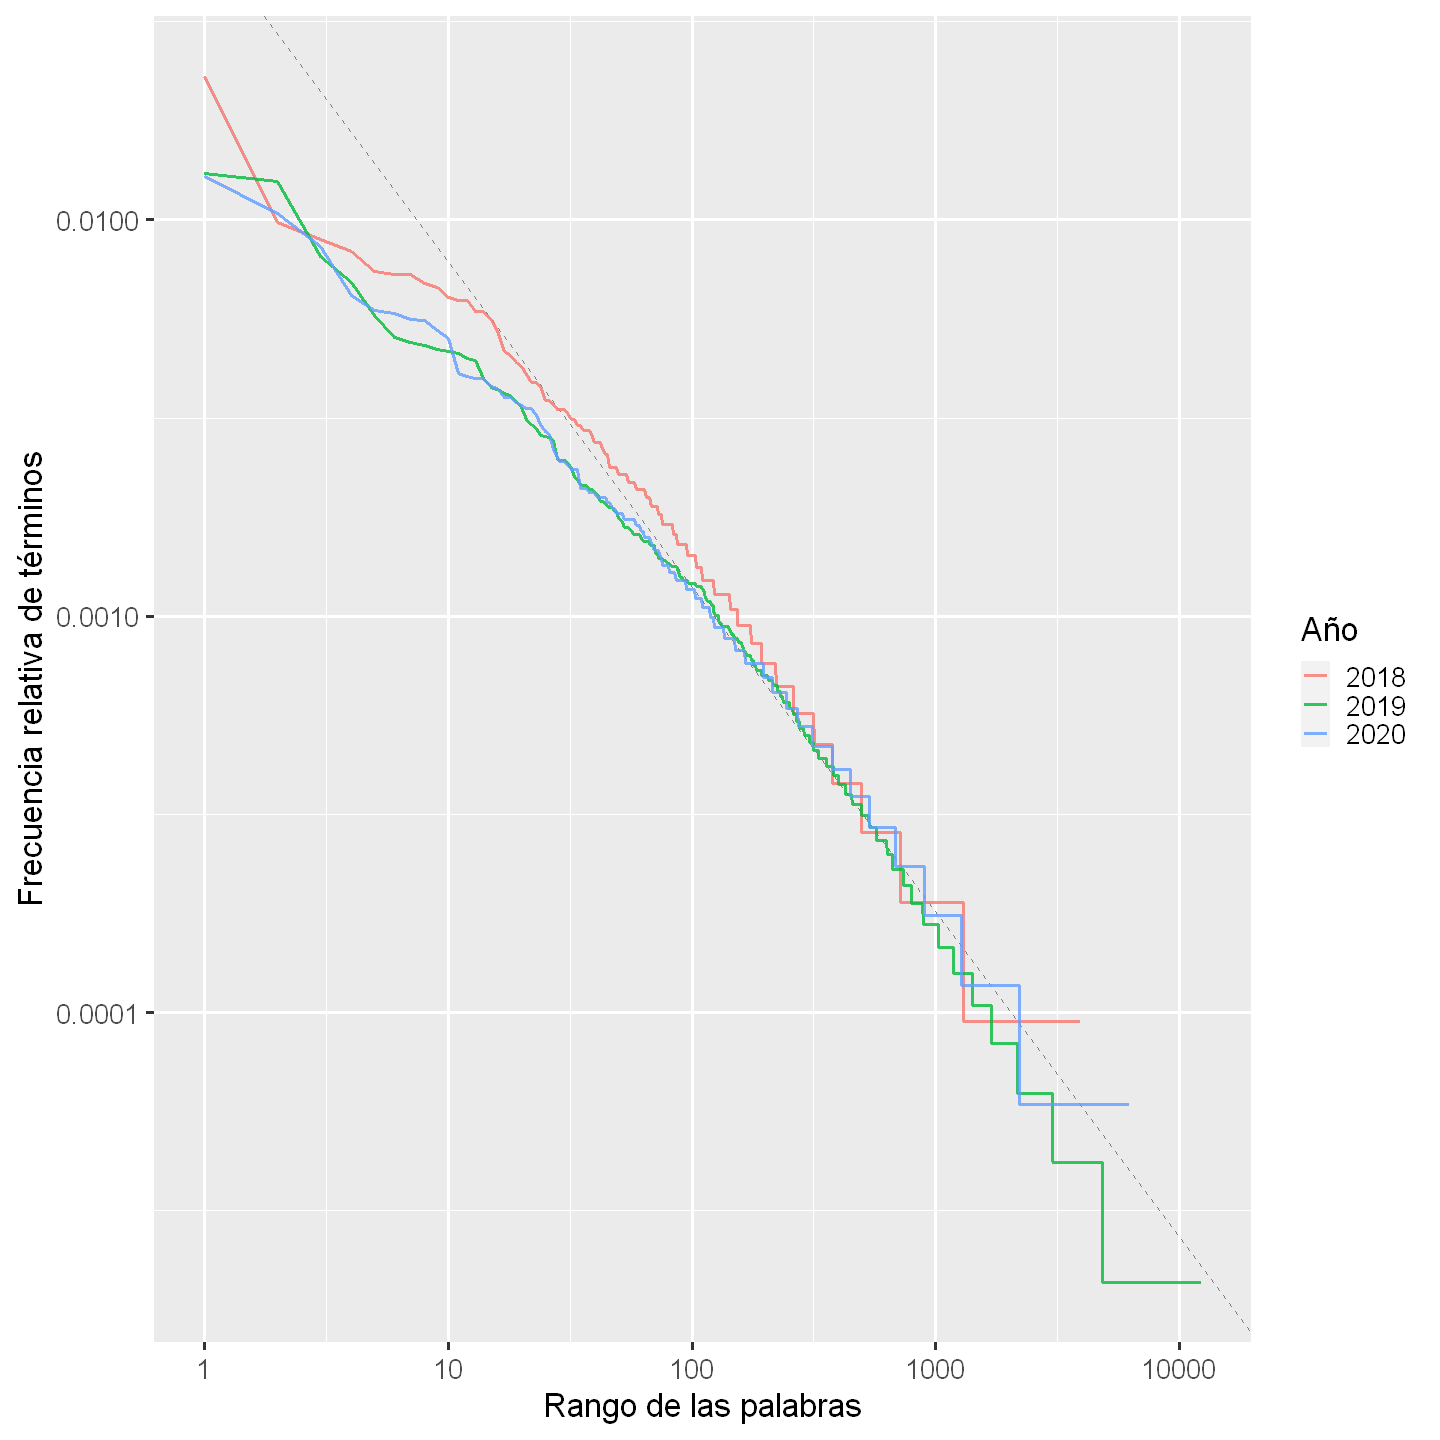

In [55]:
options(scipen=999)
frcncia.rngo %>% 
  ggplot(aes(rngo, trmno.frcncia, color = anio)) + 
  geom_abline(intercept = -1.282, slope =-0.821, color = "gray50", linetype = 2) +
  geom_line(size = 1.1, alpha = 0.8) + 
  scale_x_log10("Rango de las palabras")+
  scale_y_log10("Frecuencia relativa de términos")+scale_colour_discrete("Año")

### 3.1 Función tdidf en R.

De acuerdo con el libro de referencia: la idea de tf-idf es encontrar palabras importantes para el contenido de cada 
documento disminuyendo el peso para palabras usadas comunmente e incrementándolo para palabras que no son muy usadas en 
una colección de documentos.   La función bind_tf_idf en el paquete tidytext, toma un dataframe en formato tidy como
entrada con una fila por token por documento. Una columna contiene los tokens, otra contiene los documento, y finalmente, otra
contiene los conteos.   En el caso de la tabla anio.plbrs construida los documentos serían los años. La función se aplica de
la siguiente manera:

In [56]:
anio.plbrs1 <- anio.plbrs %>%
  bind_tf_idf(word, anio, n)

head(anio.plbrs1, 10)

anio,word,n,ttl,tf,idf,tf_idf
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
2019,cifras,626,47828,0.013088567,0,0
2019,tasa,598,47828,0.012503136,0,0
2019,ivanduque,386,47828,0.008070586,0,0
2019,aumento,332,47828,0.006941541,0,0
2019,economia,275,47828,0.005749770,0,0
2018,tasa,242,10543,0.022953619,0,0
2019,venezolanos,242,47828,0.005059798,0,0
2019,personas,235,47828,0.004913440,0,0
2019,año,231,47828,0.004829807,0,0


Se observa que términos muy comunes arrojan cero como resultado. El valor será alto para términos que son muy característicos 
de un documento. En este caso, de un año.  Se observa que las palabras cuarentena, pandemia, coronavirus y covid, que han sido
importantes en el año 2020 aparecen en los primeros lugares ordenadas por tf_idf. 

In [57]:
anio.plbrs1 %>%
  select(-ttl) %>%
  arrange(desc(tf_idf)) %>% top_n(15)

Selecting by tf_idf



anio,word,n,tf,idf,tf_idf
<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>
2020,cuarentena,59,0.003453524,1.0986123,0.003794084
2020,pandemia,52,0.003043784,1.0986123,0.003343938
2018,agosto,77,0.007303424,0.4054651,0.002961284
2018,octubre,73,0.006924025,0.4054651,0.002807451
2020,coronavirus,34,0.001990166,1.0986123,0.002186421
2020,2019,90,0.005268087,0.4054651,0.002136026
2020,covid,30,0.001756029,1.0986123,0.001929195
2018,"9,1",49,0.004647634,0.4054651,0.001884453
2019,2019,214,0.004474366,0.4054651,0.001814199


La escogencia de documento puede tener muchas formar. Por ejemplo, a continuación, los documentos son reemplazados por meses. 
Se realiza el cálculo del td-idf y se seleccionan para representar los 6 que tienen mamyor suma para esta variable.  Esto implica
recalcular los valores

In [58]:
plbrs.ms<-twts.tknzds %>% count(ms, word, sort=TRUE) 
ttl.plbrs<-plbrs.ms %>% group_by(ms) %>% summarise(ttl=sum(n))
ms.plbrs <- left_join(plbrs.ms, ttl.plbrs)
head(ms.plbrs)

`summarise()` ungrouping output (override with `.groups` argument)

Joining, by = "ms"



ms,word,n,ttl
<chr>,<chr>,<int>,<int>
2019-09,tasa,125,5918
2019-08,ivanduque,122,6438
2019-08,cifras,114,6438
2020-02,ivanduque,112,3766
2019-10,tasa,111,7187
2019-11,cifras,108,8192


El cálculo del tf_idf por mmes se realiza con el mismo procedimiento que el cálculo realizado por año. Sin embargo, ahora se
agrega un paso posterior. Se seleccionan los 8 meses cuya suma de td_idf es mayor.

In [59]:
ms.plbrs1 <- ms.plbrs %>%
  bind_tf_idf(word, ms, n) %>% arrange(-tf_idf)

sma.tf.idf<-ms.plbrs1  %>% ungroup()%>% group_by(ms) %>% summarise(tf_idf=sum(tf_idf)) %>% arrange(-tf_idf) %>% 
top_n(8) %>% select(ms)

sma.tf.idf

`summarise()` ungrouping output (override with `.groups` argument)

Selecting by tf_idf



ms
<chr>
2020-06
2020-04
2019-04
2020-05
2019-07
2019-12
2020-01
2019-05


La tabla sma.tf.idf se utiliza para filtrar los meses con mayor proporción de palabras características. Probablemente al 
graficarlos pueda verse que hayan sido meses caracterizados por eventos claramente singulares.

In [60]:
ms.plbrs1<-sma.tf.idf %>% left_join(ms.plbrs1, by=c("ms"))
head(ms.plbrs1, 10)

ms,word,n,ttl,tf,idf,tf_idf
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>
2020-06,pandemia,16,3156,0.005069708,1.7491999,0.008867933
2020-06,2020,18,3156,0.005703422,1.3437347,0.007663886
2020-06,abril,31,3156,0.009822560,0.6505876,0.006390436
2020-06,generamosdebate,5,3156,0.001584284,3.1354942,0.004967513
2020-06,juliamarin22,5,3156,0.001584284,3.1354942,0.004967513
2020-06,nicolasgomezza,5,3156,0.001584284,3.1354942,0.004967513
2020-06,rafacabamd2661,5,3156,0.001584284,3.1354942,0.004967513
2020-06,"19,8",6,3156,0.001901141,2.4423470,0.004643245
2020-06,infantil,6,3156,0.001901141,2.4423470,0.004643245


El gráfico para visualizar estos resultados se genera de la siguiente manera:

Selecting by tf_idf



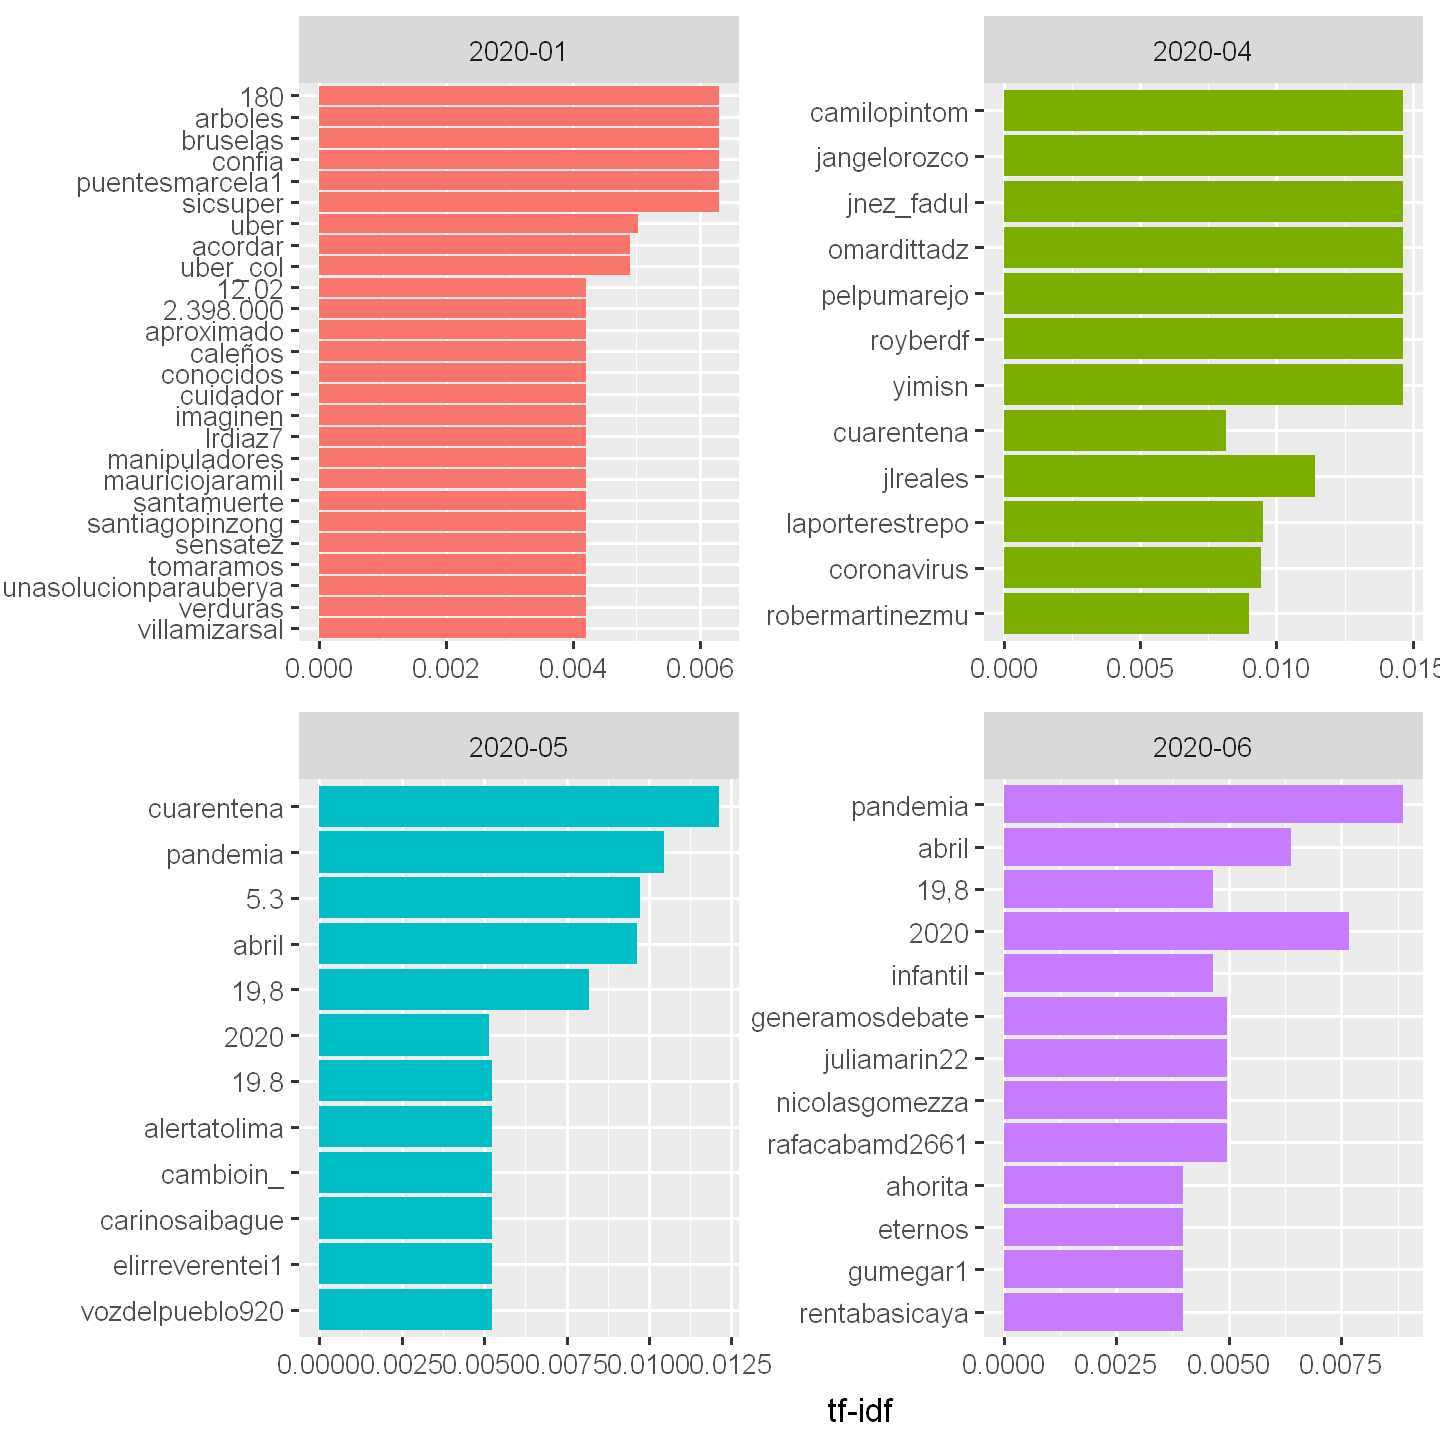

In [61]:
ms.plbrs1 %>%
  arrange(desc(tf_idf)) %>%
  mutate(word = factor(word, levels = rev(unique(word)))) %>% 
  group_by(ms) %>% 
  top_n(12) %>% 
  ungroup() %>% filter(ms%in%c("2020-05","2020-06","2020-01", "2020-04")) %>% 
  ggplot(aes(word, tf_idf, fill = ms)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~ms, ncol = 2, scales = "free") +
  coord_flip()

Selecting by tf_idf



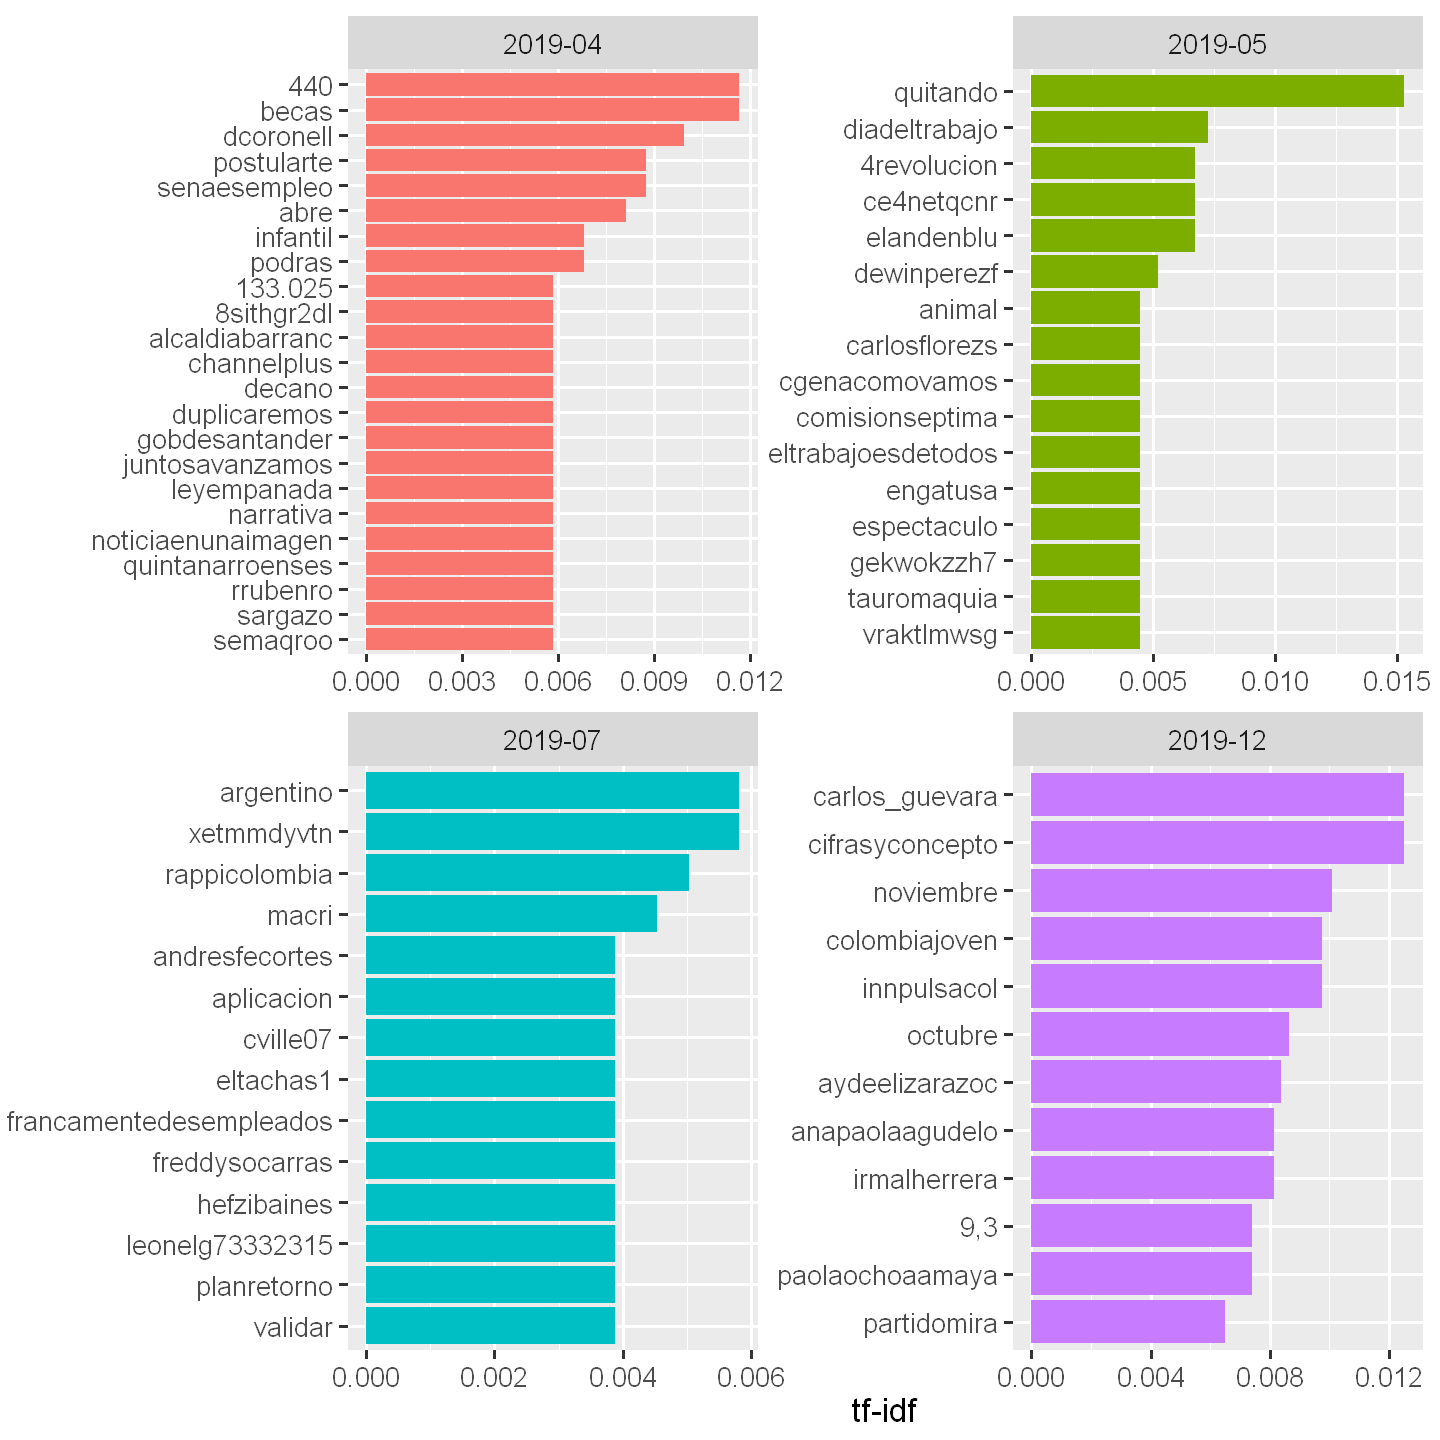

In [62]:
ms.plbrs1 %>%
  arrange(desc(tf_idf)) %>%
  mutate(word = factor(word, levels = rev(unique(word)))) %>% 
  group_by(ms) %>% 
  top_n(12) %>% 
  ungroup() %>% filter(!ms%in%c("2020-05","2020-06","2020-01", "2020-04")) %>% 
  ggplot(aes(word, tf_idf, fill = ms)) +
  geom_col(show.legend = FALSE) +
  labs(x = NULL, y = "tf-idf") +
  facet_wrap(~ms, ncol = 2, scales = "free") +
  coord_flip()

Los gráficos permiten observar algunas palabras que fueron relevantes en su momento. Entre ellos nombres propios y temas. Aparecen de nuevo en abril y junio de 2020 palabras relacionadas con la pandemia, la cuarentena estricta y las inusualescifras de
desempleo registradas en este periodo.

# Capítulo 4.  Relaciones entre palabras: n-gramas y correlaciones

Hasta el momento el análisis se ha basado en palabras, consideradas individualmente, y su relación con sentimientos o documentos.
Sin embargo, se pueden realizar muchos análisis interesantes considerando la coocurrencia de palabras. 
En este capítulo se examina la coocurrencia de palabras utilizando el argumento token="ngrams" que tokeniza pares de palabras
adyacentes. También se introducen algunos paquetes para visualizar estas relaciones.  


### 4.1 Tokenización por n-gramas

La tokenización por pares se logra mediante la introducción del parámetro token = "ngrams" en la función unnest_tokens()

In [65]:
twts.bgrms<-dts1 %>% unnest_tokens(bgrma, text, token = "ngrams", n = 2)
head(twts.bgrms, 10)

user_id,status_id,screen_name,crdo.dia,crdo.hra,bgrma
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
6937342,1229430336930668544,Albornoz,2020-02-17,15:40:08,cali ha
6937342,1229430336930668544,Albornoz,2020-02-17,15:40:08,ha sido
6937342,1229430336930668544,Albornoz,2020-02-17,15:40:08,sido la
6937342,1229430336930668544,Albornoz,2020-02-17,15:40:08,la cuidad
6937342,1229430336930668544,Albornoz,2020-02-17,15:40:08,cuidad que
6937342,1229430336930668544,Albornoz,2020-02-17,15:40:08,que más
6937342,1229430336930668544,Albornoz,2020-02-17,15:40:08,más ha
6937342,1229430336930668544,Albornoz,2020-02-17,15:40:08,ha avanzado
6937342,1229430336930668544,Albornoz,2020-02-17,15:40:08,avanzado en


#### 4.1.1 Conteo y filtro de n-gramas

A los bigramas se les calcula las frecuencias de manera similar a como se hacía para palabras individuales:

In [67]:
twts.bgrms %>%
  count(bgrma, sort = TRUE) %>% slice_head(n=10)

bgrma,n
<chr>,<int>
https t.co,3013
el dane,1497
de desempleo,1415
el desempleo,1139
en el,1085
desempleo en,994
del dane,912
tasa de,885
de empleo,857


Como puede observarse, la mayoría de las palabras contienen stopwords. Las combinaciones de mayor frecuencia no parecen
aportar mucho significado. Por este motivo se utiliza un procedimiento en el que se separan las palabras en dos columnas
y se filtran separadamente quitando los stopwords.  Los pares de palabras resultantes parecen arrojar más 
significado. El procedimiento es el siguiente:

In [69]:
bgrms.sprds <- twts.bgrms %>%
  separate(bgrma, c("word1", "word2"), sep = " ")

bgrms.fltrds <- bgrms.sprds %>%
  filter(!word1 %in% stp.wrds$word) %>%
  filter(!word2 %in% stp.wrds$word)

bgrms.unds<-bgrms.fltrds %>% 
unite(bgrma, word1, word2, sep=" ")
bgrms.unds%>% slice_head(n=10)


user_id,status_id,screen_name,crdo.dia,crdo.hra,bgrma
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
6937342,1229430336930668544,Albornoz,2020-02-17,15:40:08,años frente
6937342,1229430336930668544,Albornoz,2020-02-17,15:40:08,principales capitales
9633802,1158383705334976512,ELTIEMPO,2019-08-05,14:26:11,juanitagoe lopezjosedaniel
9633802,1158383705334976512,ELTIEMPO,2019-08-05,14:26:11,mujeres alcanza
9633802,1158383705334976512,ELTIEMPO,2019-08-05,14:26:11,"8,4 según"
9633802,1158383705334976512,ELTIEMPO,2019-08-05,14:26:11,según cifras
9633802,1158383705334976512,ELTIEMPO,2019-08-05,14:26:11,año licenciacompartida
9633802,1174673292323692544,ELTIEMPO,2019-09-19,13:15:11,cuánto ganan
9633802,1174673292323692544,ELTIEMPO,2019-09-19,13:15:11,ganan dónde


Si se quiere realizar análisis de trigramas, se puede utilizar el siguiente script: 

In [71]:
dts1 %>% unnest_tokens(trgrma, text, token = "ngrams", n =3) %>% 
separate(trgrma, c("word1", "word2", "word3"), sep = " ") %>%
  filter(!word1 %in% stp.wrds$word,
         !word2 %in% stp.wrds$word,
         !word3 %in% stp.wrds$word) %>%
  count(word1, word2, word3, sort = TRUE) %>% slice_head(n=10)

word1,word2,word3,n
<chr>,<chr>,<chr>,<int>
departamento,administrativo,nacional,55
juan,daniel,oviedo,44
colombiajoven,cifrasyconcepto,mincomercioco,33
mintrabajocol,colombiajoven,cifrasyconcepto,33
senadogovco,mintrabajocol,colombiajoven,33
anapaolaagudelo,senadogovco,mintrabajocol,30
aydeelizarazoc,anapaolaagudelo,senadogovco,30
carlos_guevara,irmalherrera,aydeelizarazoc,30
cifrasyconcepto,mincomercioco,andi_colombia,30


#### 4.1.2.  Análisis de bigramas

El formato de un token con dos palabras por fila es útil para el análisis exploratorio. En el libro se revisan las calles
más comunes de las que se habla en el texto, mediante un filtro y luego una agregación.  En el presente archivo
se filtra la palabra aumento, para identificar con qué términos se asocia.

In [72]:
bgrms.fltrds %>%
  filter(word1 == "aumento") %>%
  count(word1,word2, sort = TRUE) %>% slice_head(n=10)

word1,word2,n
<chr>,<chr>,<int>
aumento,según,8
aumento,poblacional,4
aumento,disparado,2
aumento,gobierno,2
aumento,montería,2
aumento,ostensible,2
aumento,tasa,2
aumento,"47,9",1
aumento,acá,1


Se puede calcular el tf-idf para un par de términos igual que se hizo para palabras individuales. A continuación se calcula
este indicador para el data.frame bgrms.unds.  

In [73]:
bgrms.unds<-bgrms.unds %>% mutate(anio=year(ymd(crdo.dia)))

bgrma.tf.idf <- bgrms.unds %>%
  count(anio, bgrma) %>%
  bind_tf_idf(bgrma, anio, n) %>%
  arrange(desc(tf_idf))

bgrma.tf.idf %>% slice_head(n=10)


anio,bgrma,n,tf,idf,tf_idf
<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>
2018,quibdó armenia,17,0.004288597,1.098612,0.004711506
2018,según indicadores,16,0.004036327,1.098612,0.004434358
2018,2017 senaconlasempresas,15,0.003784057,1.098612,0.004157211
2018,bucaramanga cartagena,15,0.003784057,1.098612,0.004157211
2018,cartagena santa,15,0.003784057,1.098612,0.004157211
2018,continua senacomunica,15,0.003784057,1.098612,0.004157211
2018,florencia quibdó,15,0.003784057,1.098612,0.004157211
2018,formación continua,15,0.003784057,1.098612,0.004157211
2018,ibagué pereira,15,0.003784057,1.098612,0.004157211


La representación gráfica se realiza con el mismo procedimiento para observación de frecuencias usado para
términos individuales. Es interesante que los pares de palabras con alto tf-idf son nombres o hashtags. Esto mostraría que

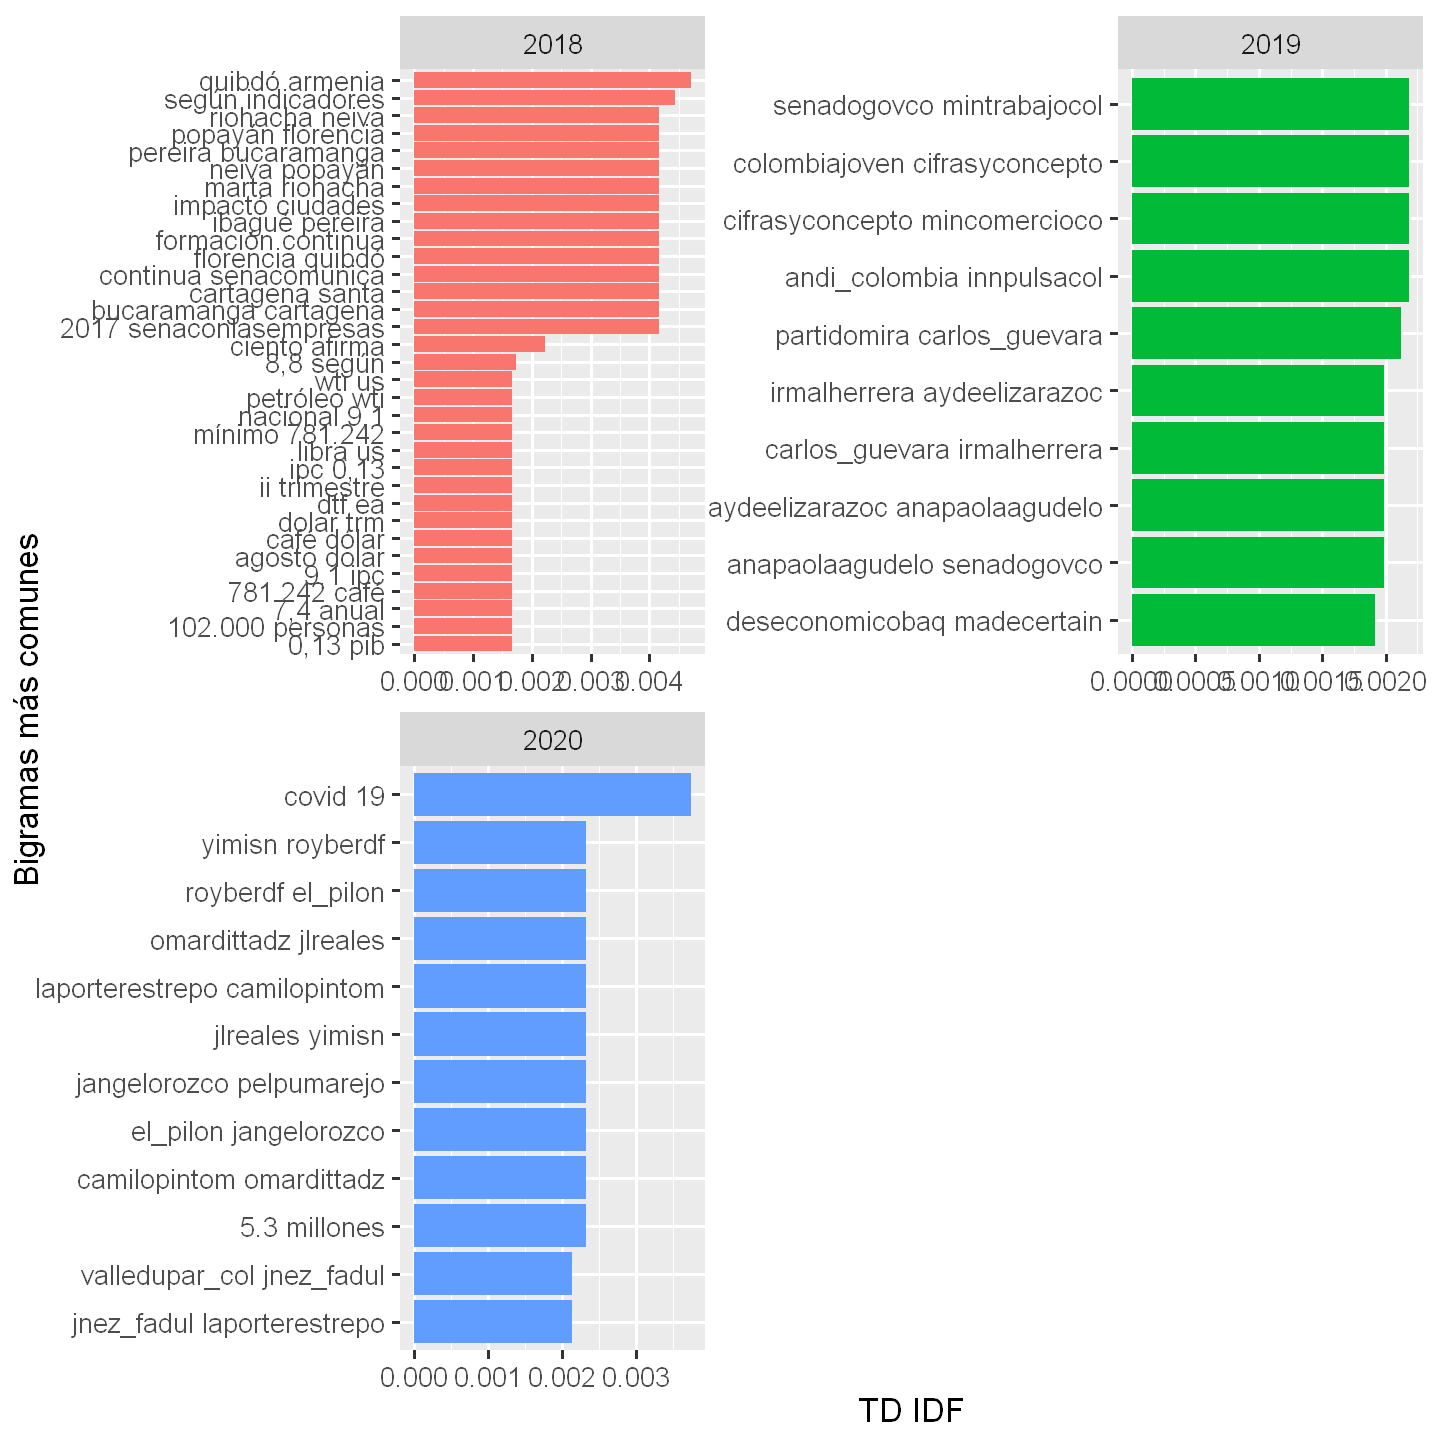

In [74]:
options(warn = -1,repr.plot.width=12, repr.plot.height=12) 

bgrma.tf.idf%>% slice_max(tf_idf, n=40)  %>% 
ggplot(aes(fct_reorder(bgrma, tf_idf), tf_idf,, fill = factor(anio)))+
geom_col()+ facet_wrap(~anio, ncol = 2, scales = "free") +
coord_flip()+theme(legend.position="none")+scale_x_discrete("Bigramas más comunes")+
scale_y_continuous("TD IDF")


De acuerdo al texto de referencia existen ventajas y desventajas de trabajar con bigramas en vez de palabras 
individuales: 1. Se capturan estructuras que no están presentes en las palabras individuales; 2. Proveen 
contexto que hacen a los tokens más comprensibles. Sin embargo, tienen la desventaja de que son mucho
más dispersos que las palabras individuales.

### 4.1.3 Uso de bigramas para proveer contexto en análisis de sentimientos.

En ocasiones el contexto de la palabra ayuda a entenderla tanto como su presencia misma. Es el caso de las
palabras precedidas por no. Para listarlas, es necesario hacer nuevamente el proceso de filtrar las palabras
por stopwords, aunque dejando la palabra no. Esto se hace con los siguientes comandos:

In [75]:
stp.wrds<-stp.wrds %>% filter(word!="no")


bgrms.sprds <- twts.bgrms %>%
  separate(bgrma, c("word1", "word2"), sep = " ")

bgrms.fltrds <- bgrms.sprds %>%
  filter(!word1 %in% stp.wrds$word) %>%
  filter(!word2 %in% stp.wrds$word)
#bgrms.sprds  %>% filter(word1=="no") %>% 
#count(word1, word2, sort=TRUE)

bgrms.unds<-bgrms.fltrds %>% 
unite(bgrma, word1, word2, sep=" ")
bgrms.unds%>% slice_head(n=10)

user_id,status_id,screen_name,crdo.dia,crdo.hra,bgrma
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
6937342,1229430336930668544,Albornoz,2020-02-17,15:40:08,años frente
6937342,1229430336930668544,Albornoz,2020-02-17,15:40:08,principales capitales
9633802,1158383705334976512,ELTIEMPO,2019-08-05,14:26:11,juanitagoe lopezjosedaniel
9633802,1158383705334976512,ELTIEMPO,2019-08-05,14:26:11,mujeres alcanza
9633802,1158383705334976512,ELTIEMPO,2019-08-05,14:26:11,"8,4 según"
9633802,1158383705334976512,ELTIEMPO,2019-08-05,14:26:11,según cifras
9633802,1158383705334976512,ELTIEMPO,2019-08-05,14:26:11,año licenciacompartida
9633802,1174673292323692544,ELTIEMPO,2019-09-19,13:15:11,cuánto ganan
9633802,1174673292323692544,ELTIEMPO,2019-09-19,13:15:11,ganan dónde


In [76]:
bgrms.fltrds %>%
  filter(word1 == "no") %>%
  count(word1, word2, sort = TRUE) %>% slice_head(n=10)

word1,word2,n
<chr>,<chr>,<int>
no,dañe,31
no,afecta,21
no,genera,20
no,sé,19
no,entiendo,16
no,cuentan,11
no,sirve,10
no,aumenta,8
no,crece,8


Con el lexicón afin, que se utilizó en los ejercicios anteriores, se puede identificar cuando la polaridad de una palabra debe ser cambiada por estar precedida de un no. Se carga el lexicón Affin, para realizar este ejercicio.

In [77]:
setwd('C:\\1Proyectos\\2020_06_28_Tweets_Dane_2\\Datos\\Lexicones')

affn<-read_csv("lexico_afinn.en.es.csv") %>% 
  mutate(plbra=parse_character(Palabra, locale = locale(encoding = "Latin1"))) %>% 
  select(plbra, pntcn=Puntuacion) %>% mutate(plbra=chartr("áéíóú", "aeiou", plbra))

Parsed with column specification:
cols(
  Palabra = col_character(),
  Puntuacion = col_double(),
  Word = col_character()
)



In [78]:
plbrs.no <- bgrms.fltrds %>%
  filter(word1 == "no") %>%
  inner_join(affn,  by=c("word2"="plbra")) %>%
  count(word2, pntcn,sort = TRUE)

plbrs.no %>% slice_head(n=10)

#twts.sntmnts<-twts.tknzds %>% inner_join(afnn, by=c("word"="plbra")) 

word2,pntcn,n
<chr>,<dbl>,<int>
aumenta,1,8
mejora,2,8
ayuda,2,4
no,-1,4
permitir,1,3
perseguir,-2,2
crecimiento,2,1
dejar,-1,1
empeorar,-3,1


El peso en la dirección equivocada de estas negaciones está en función del número de ocurrencias, 
pero también en función de la valencia del sentimiento.  La mayoría de estos elementos considera una
serie de elementos para el manejo de varios temas.

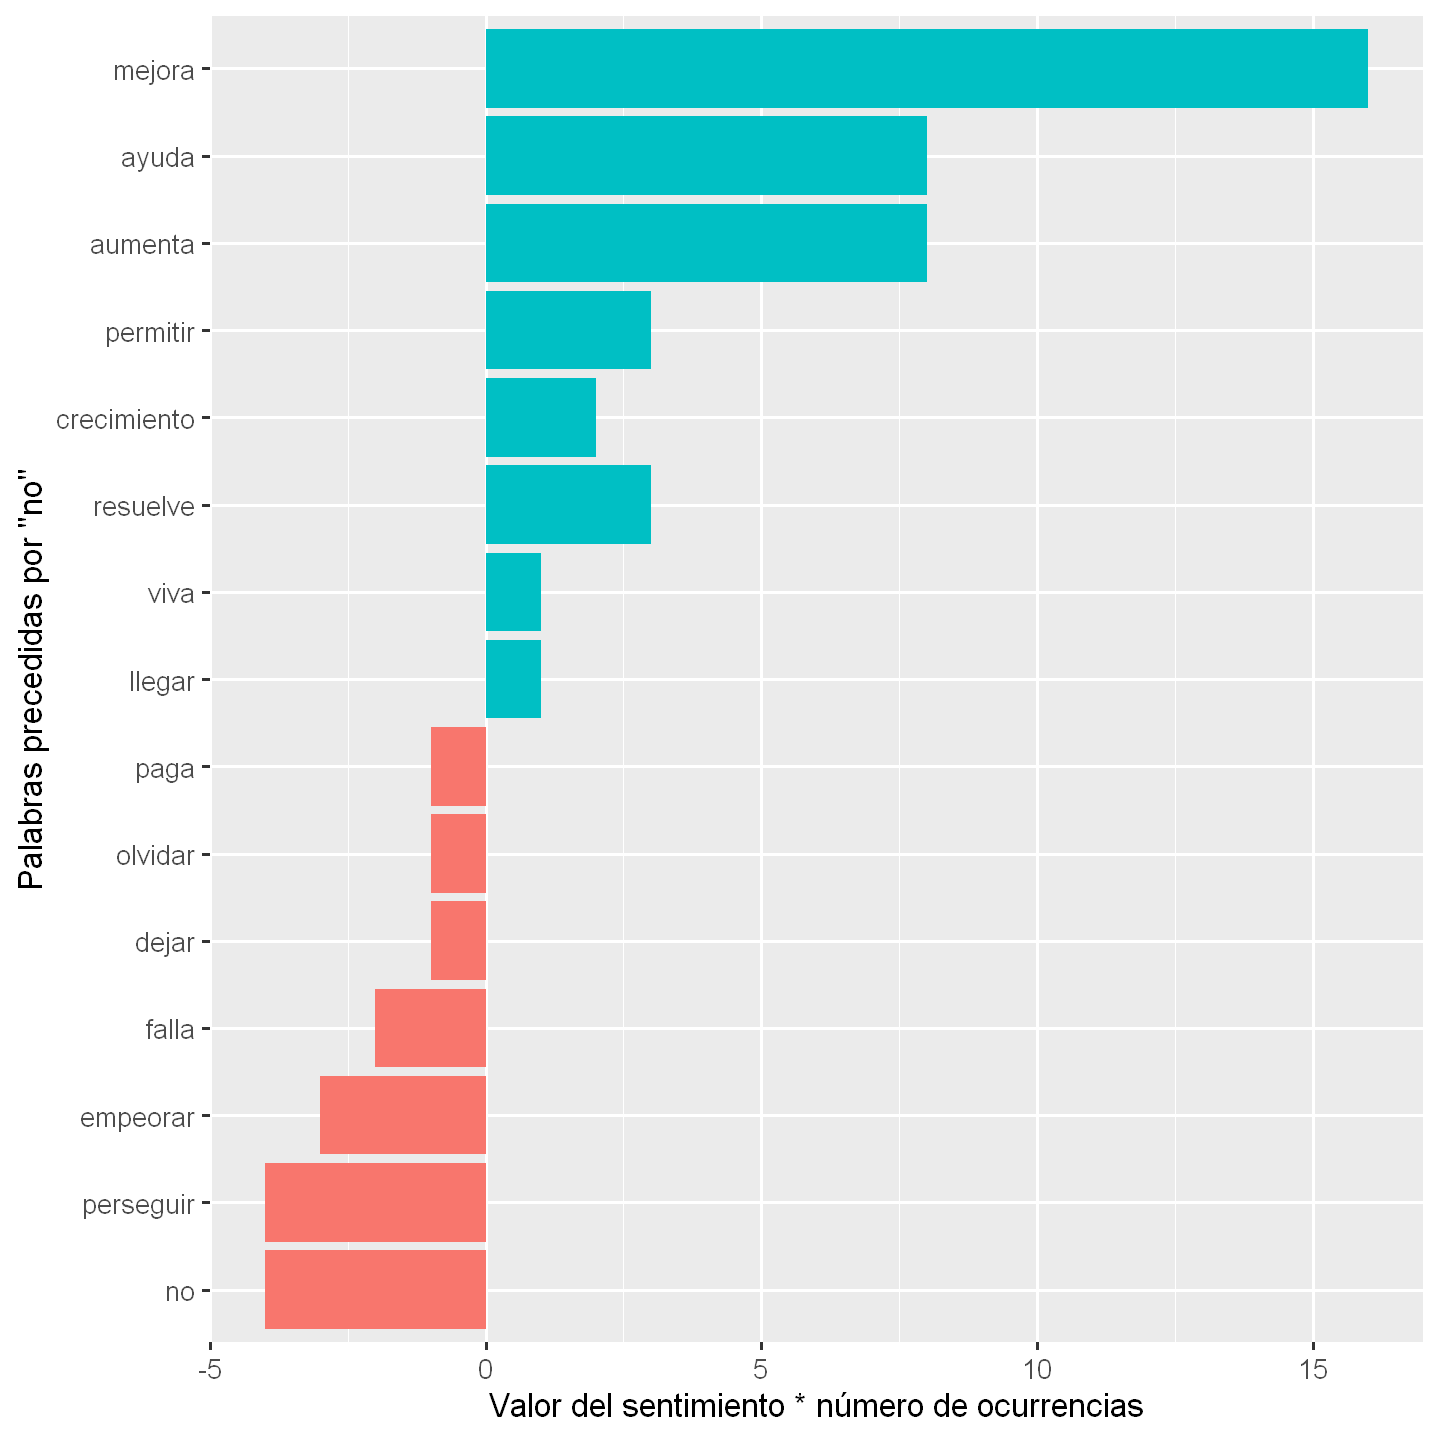

In [79]:
plbrs.no %>%
  mutate(cntrbcn = n * pntcn) %>%
  arrange(desc(abs(cntrbcn))) %>%
  head(20)%>%
  mutate(word2 = reorder(word2, cntrbcn)) %>% 
ggplot(aes(word2, n * pntcn, fill = n * pntcn > 0)) +
  geom_col(show.legend = FALSE) +
  xlab("Palabras precedidas por \"no\"") +
  ylab("Valor del sentimiento * número de ocurrencias") +
  coord_flip()

No no es el único término que niega la palabra que está adelante. También sucede con nunca, jamás, sin y ningún,
entre otros.  A continuación se analizan estos términos.

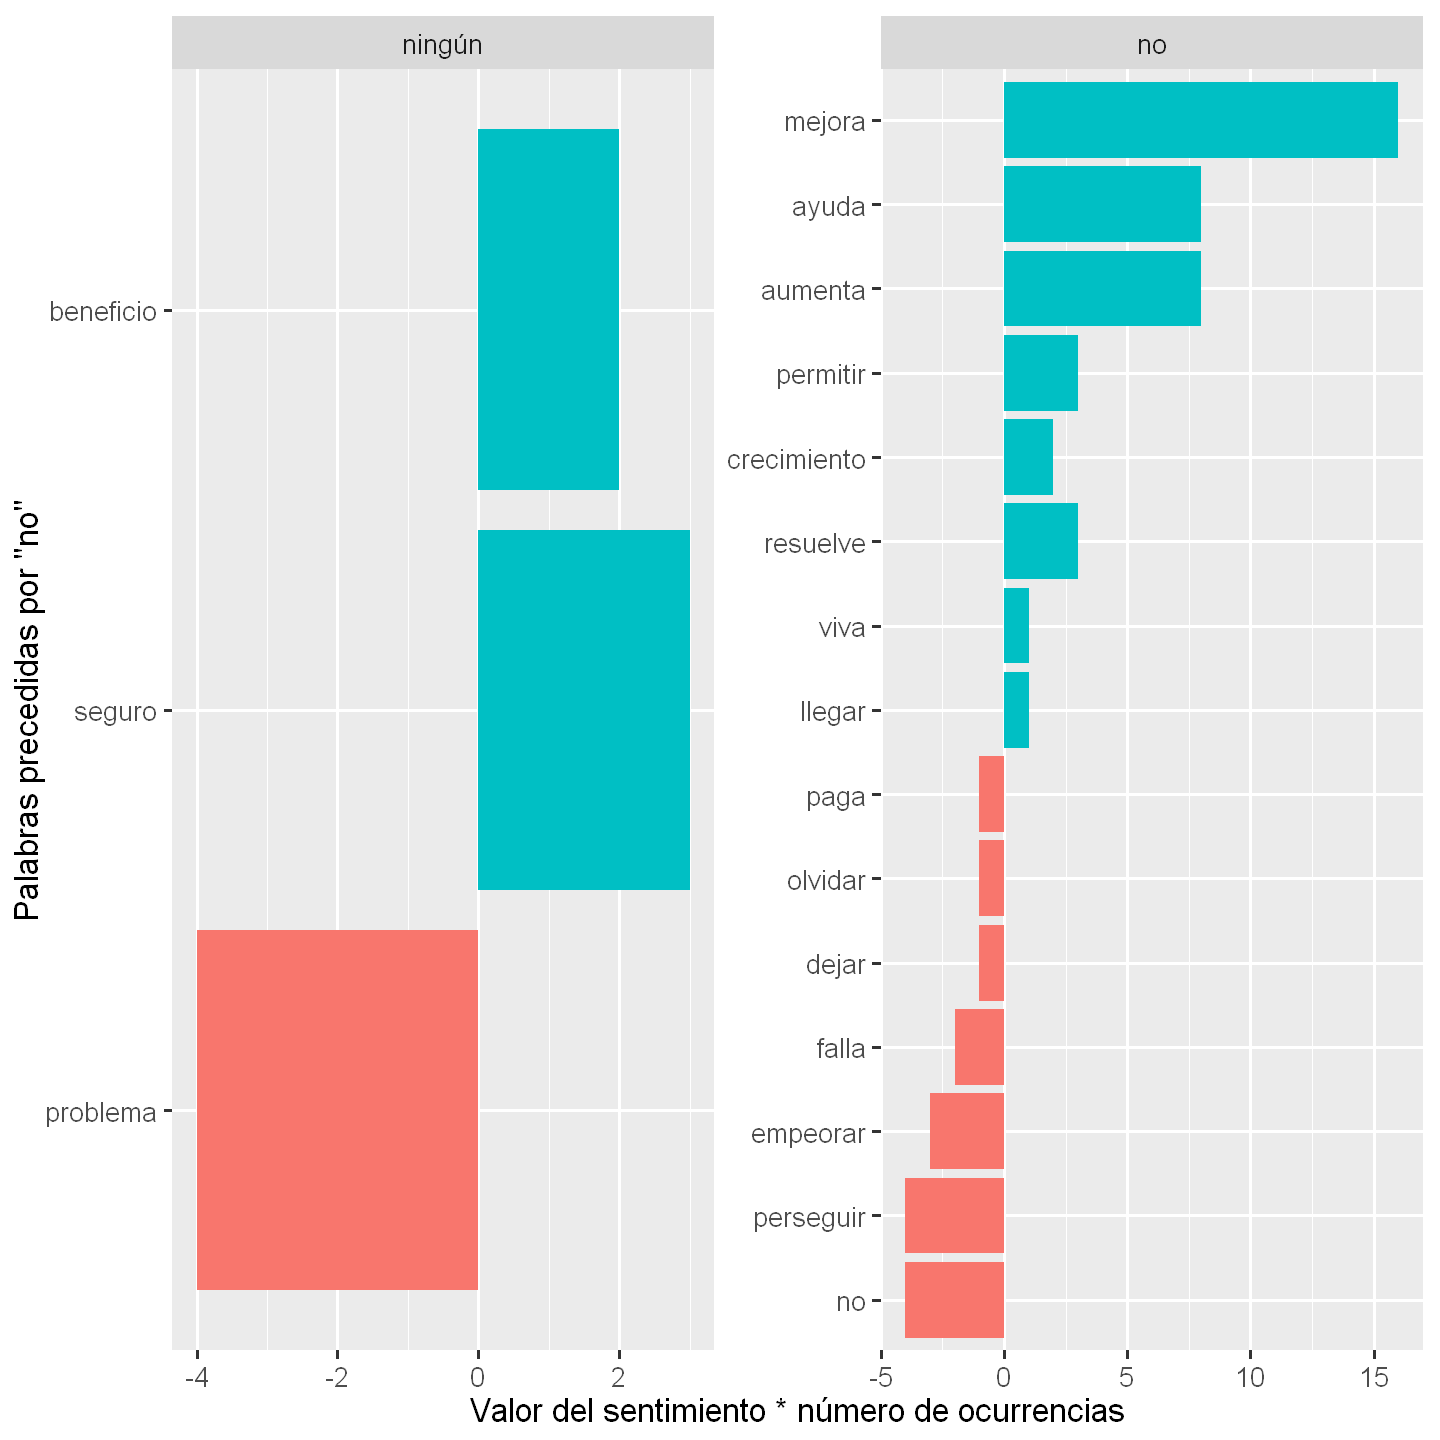

In [80]:
plbrs.ngcn <- c("no", "nunca", "jamas", "sin","ningún")

bgrms.fltrds %>%
  filter(word1 %in% plbrs.ngcn) %>%
  inner_join(affn, by = c(word2 = "plbra")) %>%
  count(word1, word2, pntcn, sort = TRUE) %>%
  mutate(cntrbcn = n * pntcn) %>%
  arrange(desc(abs(cntrbcn))) %>%
  head(20)%>%
  mutate(word2 = reorder(word2, cntrbcn)) %>% 
ggplot(aes(word2, n * pntcn, fill = n * pntcn > 0)) +
  geom_col(show.legend = FALSE) +
  xlab("Palabras precedidas por \"no\"") +
  ylab("Valor del sentimiento * número de ocurrencias") +
  coord_flip()+ facet_wrap(~word1, ncol = 2, scales = "free")

Esta aproximación puede usarse para invertir la polaridad de los tweets que comienzan con una negación. Por ejemplo en el caso en que se realice un análisis de sentimientos con bigramas. 

### 4.1.4 Visualización de redes de bigramas.

Para visualizar las relaciones entre todas las palabras al tiempo, más que una a la vez, se puede convertir
el conjunto de palabras en un grafo. Un grafo puede construirse a partir de un objeto tidy a partir de tres
variables: from, to y weight.  From es el nodo desde el que un eje se origina, to es el nodo hacia el que un
eje se aproxima y weight es un valor numérico asociado con dada eje.  Para crear un grafo desde un dataframe 
el libro recomienda utilizar la función graph from dataframe.  Como se ve abajo, en el dataframe se tienen
las palabras de orígen y destino y un valor n dado por el número de ocurrencias conjuntas. Posteriormente
se observan el objeto una parte del objeto resultante luego de la transformación a grafo.

In [81]:
bgrms.cnteo<-bgrms.fltrds %>% count(word1, word2)
bgrms.cnteo %>% head()

grfo.bgrms<-bgrms.cnteo %>% filter(n>20) %>% graph_from_data_frame()
grfo.bgrms

word1,word2,n
<chr>,<chr>,<int>
_bouree,annalvarezg,1
_eduarj,clistiene,1
_fransua,twiteroscali,1
_keylagarcia,jareiza29,1
_marcestrada,acaba,1
_medicenandres,aabenedetti,1


IGRAPH 4c94ff3 DN-- 94 61 -- 
+ attr: name (v/c), n (e/n)
+ edges from 4c94ff3 (vertex names):
 [1] 12             ->meses           13             ->ciudades       
 [3] 13             ->principales     23             ->ciudades       
 [5] 39             ->actividades     actividades    ->industriales   
 [7] administrativo ->nacional        anapaolaagudelo->senadogovco    
 [9] andi_colombia  ->innpulsacol     áreas          ->metropolitanas 
[11] aydeelizarazoc ->anapaolaagudelo carlos_guevara ->irmalherrera   
[13] cifrasyconcepto->mincomercioco   clase          ->media          
[15] colombiajoven  ->cifrasyconcepto covid          ->19             
+ ... omitted several edges

La representación que se recomienda en el libro es mediante el paquete ggraph, que implementa una
visualización basada en la gramática de gráficos, igual que el paquete ggplot2.

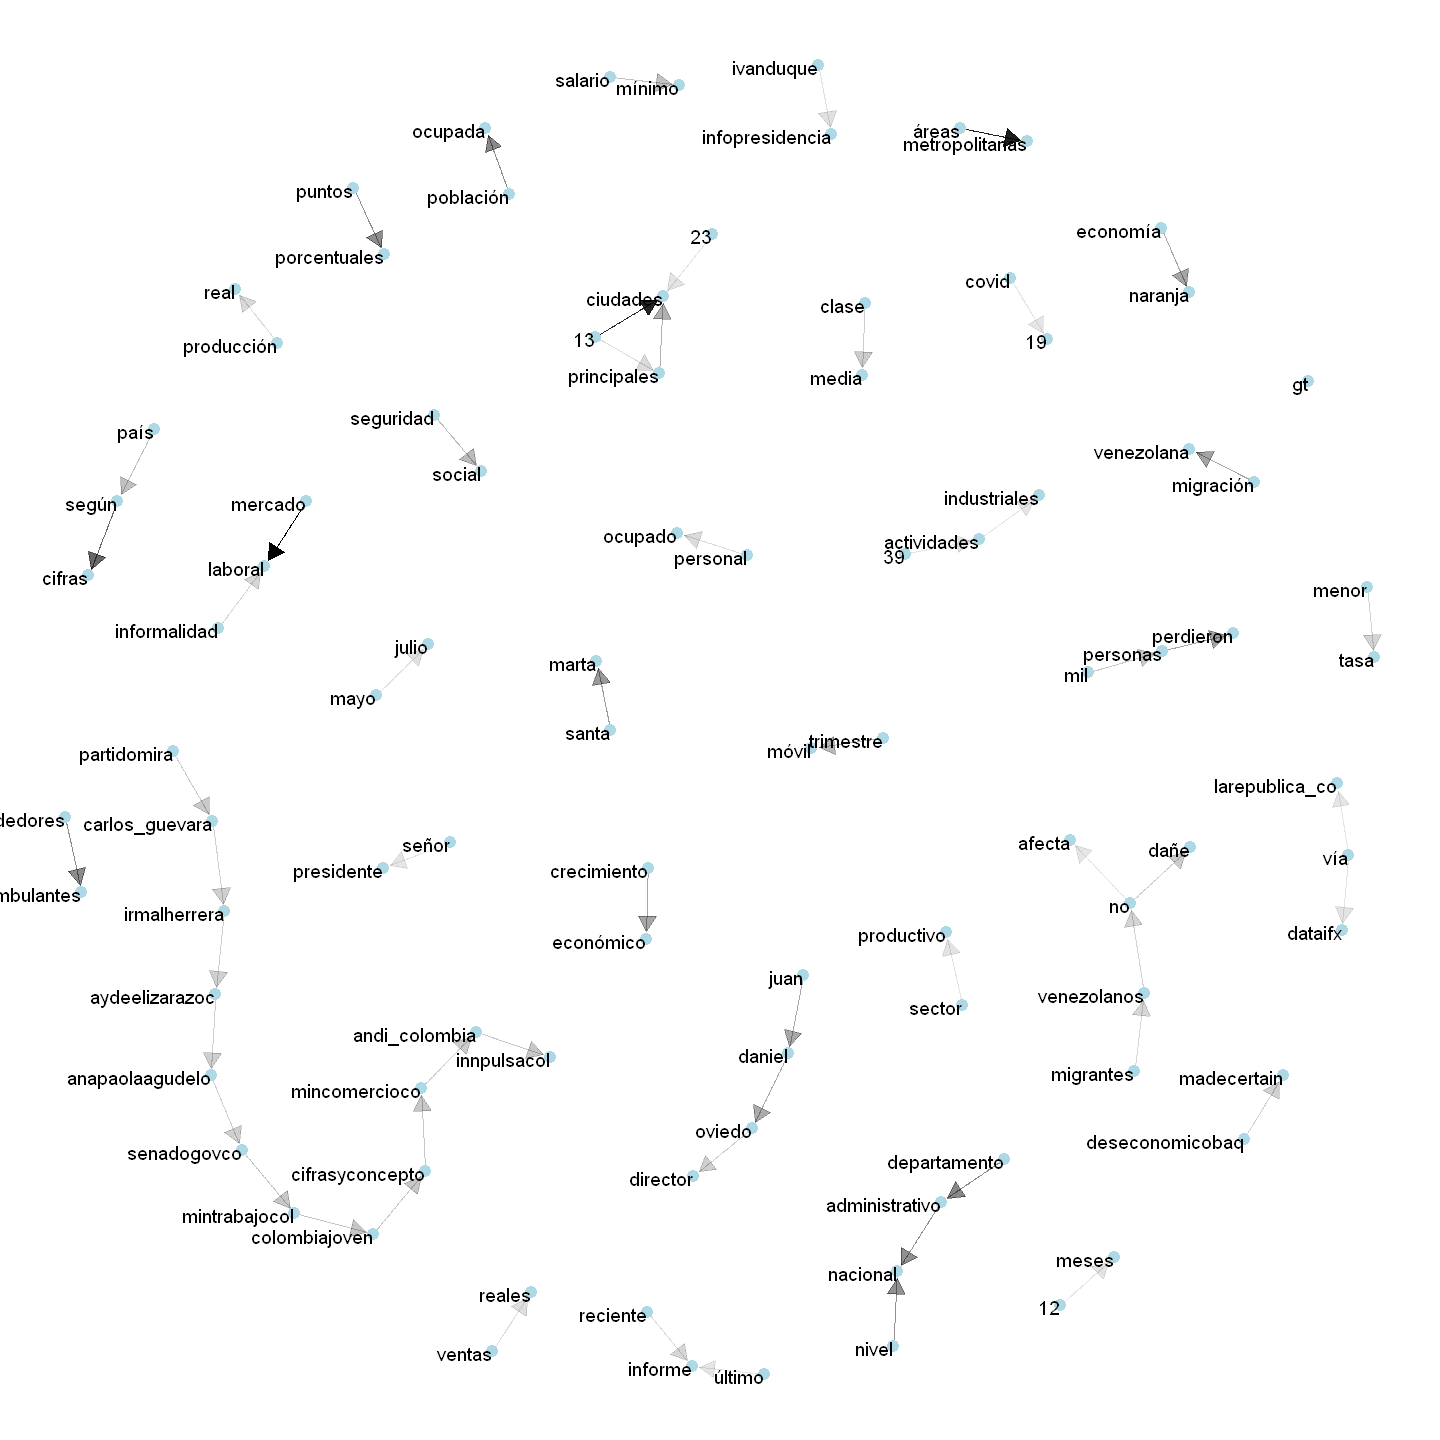

In [82]:
set.seed(2017)

a <- grid::arrow(type = "closed", length = unit(.15, "inches"))

ggraph(grfo.bgrms, layout = "fr") +
  geom_edge_link(aes(edge_alpha = n), show.legend = FALSE,
                 arrow = a, end_cap = circle(.06, 'inches')) +
  geom_node_point(color = "lightblue", size = 3) +
  geom_node_text(aes(label = name), vjust = 1, hjust = 1, size=4) +
  theme_void()

## 4.2 Conteo y correlación de pares de palabras con 

Además de la identificación de palabras que aparecen juntas, se puede estar interesado en la coocurrencia de palabras en
diferentes textos, independientemente de si aparecen una al lado de la otra. Por ejemplo analizando qué tan frecuente
es la coocurrencia de dos palabras dentro de un mismo documento, o identificando qué tan correlacionadas están. El formato tidy no es el más apropiado para realizar este tipo de ejercicios, por lo que es necesario realizar transformaciones de las tablas. La mayoría de las operaciones para identificar coocurrencia por pares o  correlaciones requiere una matrix de palabras por palabras. 

El libro ilustra el proceso de transformación para realizar las anteriores operaciones. En primer lugar se pasa de una estructura tidy a una tabla de formato áncho, realiza la operación y finalmente hace una trasnformación para devolver los datos a un formato tidy.

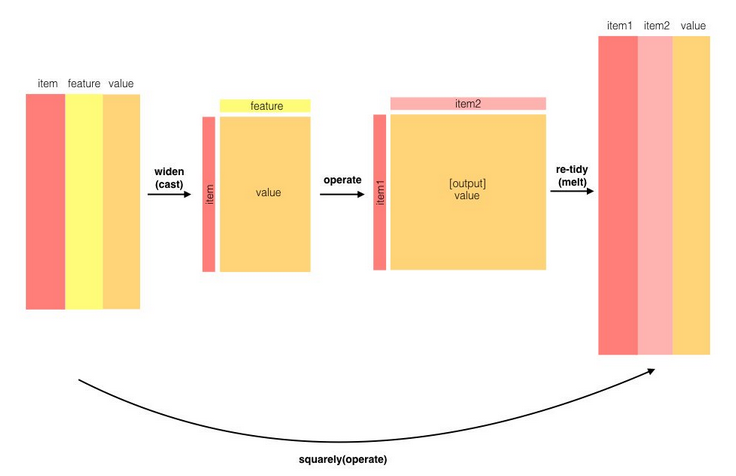

In [84]:
setwd('C:\\1Proyectos\\2020_06_28_Tweets_Dane_2\\Datos')
display_png(file='4_2_tidy_a_matrix_ancha.png')  

### 4.2.1 Conteo y correlación entre secciones. 

El texto de referencia analiza la coocurrencia de palabras dentro de capítulos de libro. En el presente texto se
analizará la coocurrencia de palabras por meses en los tweets considerados. Se utiliza el dataframe twts.tknzds, que se
había construido anteriormente. Se dejan únicamente las palabras

In [85]:
plbrs.sccns<- dts1 %>% unnest_tokens(word, text) %>%
  mutate(word1 = str_extract(word, "[a-z']+")) %>% 
  anti_join(stp.wrds) %>% filter(!screen_name=="DANE_Colombia") %>%  mutate(crdo.dia=ymd(crdo.dia), 
                                    crdo.hra=hms(crdo.hra)) %>% 
  mutate(anio=format(crdo.dia,"%Y"), ms=format(crdo.dia, "%Y-%m")) %>% select(anio, ms, word)

head(plbrs.sccns, 5)

Joining, by = "word"



anio,ms,word
<chr>,<chr>,<chr>
2020,2020-06,felizmartes
2020,2020-06,abril
2020,2020-06,"5,3"
2020,2020-06,millones
2020,2020-06,personas


El paquete widyr tiene una función llamada pairwise_count(), tiene como objetivo generar una frecuencia para cada par
de palabras en la misma sección.   Puede observarse que las palabras más comunes se relacionan con la palabra "millones"

In [86]:
prs.plbrs <- plbrs.sccns %>%
  pairwise_count(word, ms, sort = TRUE)
head(prs.plbrs)

item1,item2,n
<chr>,<chr>,<dbl>
personas,millones,23
según,millones,23
no,millones,23
mil,millones,23
año,millones,23
cifras,millones,23


### 4.2.2  Correlaciones por pares 

La correlación por pares permite identificar las palabras en función qué tan a menudo aparecen juntas, en relación a qué tan
a menudo aparecen separadas. Para ello se utiliza el coeficiente phi, una medida de correlación binaria.  El énfasis de
este estadístico es determinar la relación entre la aparición conjunta de las variables respecto a su aparición por separado. Dada una tabla como la siguiente:


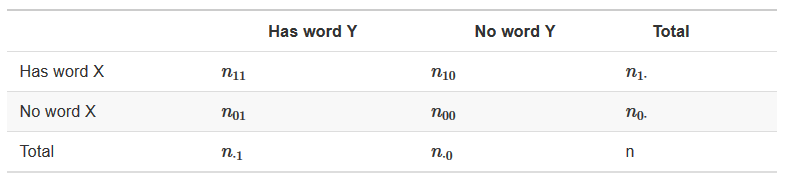

In [87]:
setwd('C:\\1Proyectos\\2020_06_28_Tweets_Dane_2\\Datos')
display_png(file='4_2_tabla_correlación_binaria.png')  

Su fórmula se expresa como:

$\phi=\frac{n_{11}n_{00}-n_{10}n_{01}}{\sqrt n1. n0. n.0 n.1}$ 

Se interpreta de manera similar al coeficiente de Pearson. Con un valor de 1 sifnificando asociación completa, cero falta de asociación y menos uno una perfecta correlación negativa.  Con la función  pairwise_cor del paquete  calcula la correlación. 

In [ ]:
crrlcn.plbrs<-plbrs.sccns %>% 
   group_by(word) %>% 
filter(n()>=10) %>% 
pairwise_cor(word, ms, sort=TRUE, use="complete.obs")

head(crrlcn.plbrs, 10)


Las correlaciones más altas suelen ser nombres, por el momento no dicen mucho al análisis temático,
razón por la cual se eliminan para observar relaciones entre otras palabras. Se filtran los valores de uno

El formato tidy permite realizar filtros de correlaciones con palabras de interés

Selecting by correlation



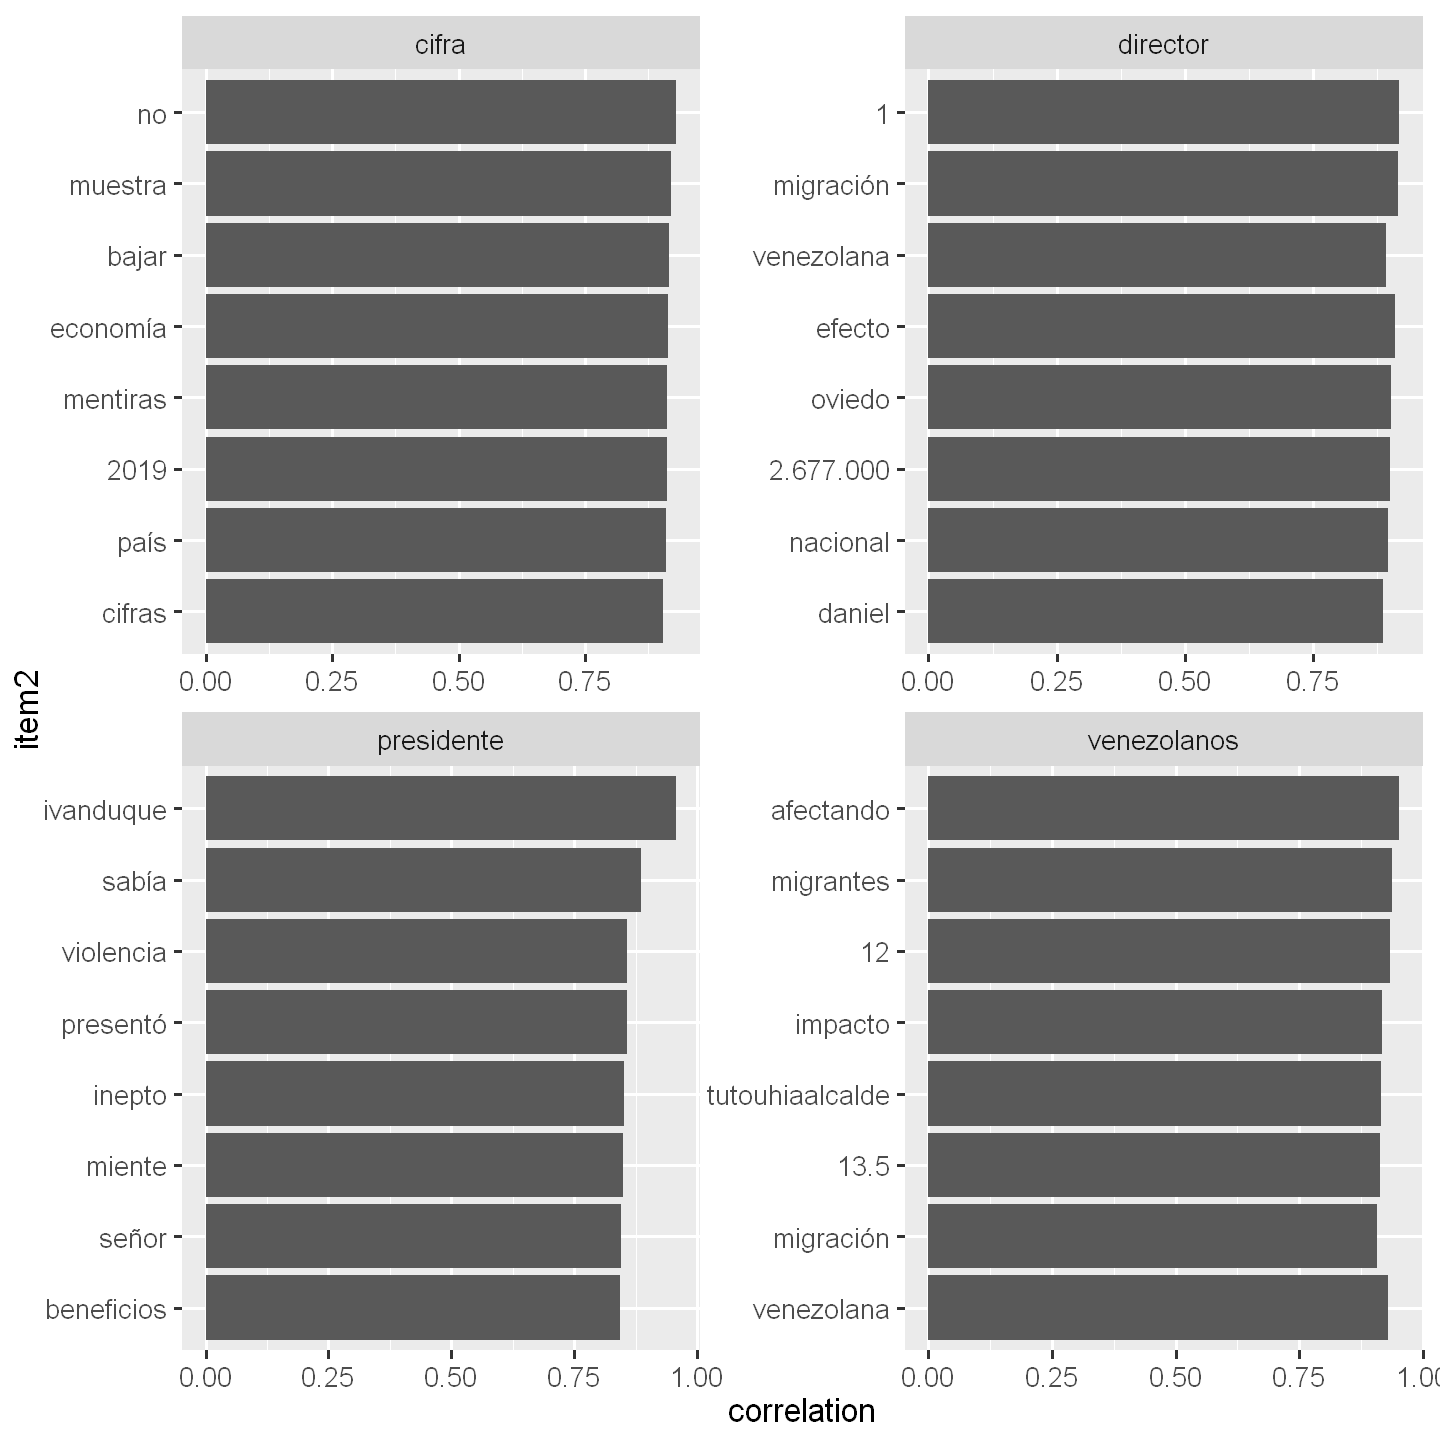

In [89]:
crrlcn.plbrs %>%
  filter(item1 %in% c("presidente", "director", "venezolanos", "cifra")) %>%
  group_by(item1) %>%
  top_n(8) %>%
  ungroup() %>%
  mutate(item2 = reorder(item2, correlation)) %>%
  ggplot(aes(item2, correlation)) +
  geom_bar(stat = "identity") +
  facet_wrap(~ item1, scales = "free") +
  coord_flip()

De la misma manera que con las palabras contiguas, las matrices de palabras se pueden representar a través de grafos.

In [ ]:
set.seed(2016)

crrlcn.plbrs %>%
  filter(correlation > .9) %>%
  graph_from_data_frame() %>%
  ggraph(layout = "fr") +
  geom_edge_link(aes(edge_alpha = correlation), show.legend = FALSE) +
  geom_node_point(color = "lightblue", size = 5) +
  geom_node_text(aes(label = name), repel = TRUE) +
  theme_void()

A diferencia de la red de palabras contiguas en este caso es posible identificar estructuras más complejas y conectadas. 


# Glosario

* **n-grama**: subsecuencia de n elementos de una secuencia dada.

* **stopwords**: (o palabras vacías), stas palabras no tienen un significado por si solas, sino que modifican o acompañan a otras, este grupo suele estar conformado por artículos, pronombres, preposiciones, adverbios e incluso algunos verbos.



# Referencias

Anturi-Martínez, J. P., Paz-Realpe, J. L., Timaná-Peña, J. A., & Cobos, C. (2019). Clasificadores para el Análisis de Sentimientos en Twitter: una revisión. Revista Ibérica de Sistemas e Tecnologias de Informação, (E23), 353-366.

Bakshi, R. K., Kaur, N., Kaur, R., & Kaur, G. (2016, March). Opinion mining and sentiment analysis. In 2016 3rd International Conference on Computing for Sustainable Global Development (INDIACom) (pp. 452-455). IEEE.

Nielsen, F. Å. (2011). A new ANEW: Evaluation of a word list for sentiment analysis in microblogs. arXiv preprint arXiv:1103.2903.

Liu, B. (2012). Sentiment analysis and opinion mining. Synthesis lectures on human language technologies, 5(1), 1-167.



# Enlaces de consulta

repositorio de consulta AFINN: http://www2.imm.dtu.dk/pubdb/pubs/6010-full.html
https://medium.com/@himanshu_23732/sentiment-analysis-with-afinn-lexicon-930533dfe75b